라이브러리

In [18]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean, cosine, correlation
from sklearn.metrics import mean_squared_error, mean_absolute_error, pairwise_distances
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 1
model_name = ['tank'+str(tank)+'_lstm_all', 'tank'+str(tank)+'_lstm_only-feed_no180', 'tank'+str(tank)+'_lstm_crop720_only-feed']

In [19]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [20]:
#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_food_supply_tb.csv")
japonica_validation_sensor_val = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_sensor_val_tb.csv")

In [21]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [22]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_validation_sensor_val_tb = japonica_validation_sensor_val[japonica_validation_sensor_val['tank_id']==tank]

#시계열 변환
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


C:\Users\rladn\AppData\Local\Temp\ipykernel_13188\778596347.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
C:\Users\rladn\AppData\Local\Temp\ipykernel_13188\778596347.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
C:\Users\rladn\AppData\Local\Temp\ipykernel_13188\778596347.py:9: Set

In [23]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

#문제 날짜 삭제
date_to_remove = pd.to_datetime('2021-08-03')
japonica_validation_data = japonica_validation_data.drop(japonica_validation_data[japonica_validation_data.index.date == date_to_remove.date()].index)

In [24]:
japonica_validation_features_X_a = japonica_validation_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation_features_X_b = japonica_validation_data[['feed_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

모델 평가

In [243]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('x')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)
    
def grapeNEva5(y_test, X_test_shape, feed):
    model = []
    array_index = 0
    
    for i in range(len(model_name)):
        model.append(load_model(model_name[i]+'.h5', custom_objects={'r_squared': r_squared}))
    
    X_pred1 = model[0].predict(X_test_shape)
    X_pred1 = np.asarray(X_pred1, dtype=np.float64)
    X_pred1 = X_pred1.reshape((-1))

    X_pred2_result_array = np.asarray(feed)
    X_pred2_result_array = X_pred2_result_array.reshape((-1, 1, 1))
    X_pred2_result = model[1].predict(X_pred2_result_array)
    X_pred2_result = np.asarray(X_pred2_result, dtype=np.float64)
    X_pred2_result = X_pred2_result.reshape((-1))
    X_pred2_result2 = np.zeros(len(feed))

    ones_array = np.ones(len(feed))
    X_pred3_result = np.ones(len(feed))
    X_pred3_result2 = np.ones(len(feed))
    X_pred5_result = np.ones(len(feed))

    nomal_result = np.ones(len(feed))

    for i in range(len(feed)):
        if feed[i] > 0 :
            nomal_array = np.asarray(0)
            nomal_array = nomal_array.reshape((-1, 1, 1))
            nomal = model[1].predict(nomal_array)
            nomal = np.asarray(nomal, dtype=np.float64)
            nomal = nomal.reshape((-1))

            array_index = i
            X_pred2_array = np.asarray(feed[i])
            X_pred2_array = X_pred2_array.reshape((-1, 1, 1))
            X_pred2 = model[1].predict(X_pred2_array)
            X_pred2 = np.asarray(X_pred2, dtype=np.float64)
            X_pred2 = X_pred2.reshape((-1)) 
            
            array_length = 720
            X_pred3_array = np.zeros(array_length)
            X_pred3_array[270] = feed[i]
            X_pred3_array = X_pred3_array.reshape((-1, array_length, 1))
            X_pred3 = model[2].predict(X_pred3_array)
            X_pred3 = np.asarray(X_pred3, dtype=np.float64)
            X_pred3 = X_pred3.reshape((-1))

            nomaln = np.ones(array_length) * nomal

            X_pred2n = np.zeros(array_length) - X_pred2 / nomal
            X_pred3n = X_pred3 / nomal
            X_pred4 = X_pred3 / (X_pred2 * -1) / nomal
            X_pred5 = X_pred3 * X_pred2
            
            x = 0
            if array_index < 270 :
                x = 270 - array_index
                X_pred4 = X_pred4[x:]
                X_pred2 = X_pred2[x:]
                X_pred2n = X_pred2n[x:]
                X_pred3 = X_pred3[x:]
                X_pred3n = X_pred3n[x:]
                X_pred5 = X_pred5[x:]
                nomaln = nomaln[x:]


            X_pred2_result[array_index+x-270:array_index-270+x+len(X_pred2)] = X_pred2_result[array_index+x-270:array_index-270+x+len(X_pred2)]
            X_pred2_result2[array_index+x-270:array_index-270+x+len(X_pred2n)] = X_pred2_result2[array_index+x-270:array_index-270+x+len(X_pred2n)] + X_pred2n
            X_pred3_result[array_index+x-270:array_index-270+x+len(X_pred3)] = X_pred3_result[array_index+x-270:array_index-270+x+len(X_pred3)] * X_pred3
            X_pred3_result2[array_index+x-270:array_index-270+x+len(X_pred3n)] = X_pred3_result2[array_index+x-270:array_index-270+x+len(X_pred3n)] * X_pred3n
            X_pred5_result[array_index+x-270:array_index-270+x+len(X_pred5)] = X_pred5_result[array_index+x-270:array_index-270+x+len(X_pred5)] * X_pred5
            ones_array[array_index+x-270:array_index-270+x+len(X_pred4)] = ones_array[array_index+x-270:array_index-270+x+len(X_pred4)] * X_pred4
            nomal_result[array_index+x-270:array_index-270+x+len(nomaln)] = nomal_result[array_index+x-270:array_index-270+x+len(nomaln)] * nomaln

    #X_pred5_mean = np.mean(X_pred5_result)
    #ones_array = X_pred5_result / X_pred5_mean
    ones_array2 = ((X_pred2_result + X_pred3_result)/2) / nomal_result
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank sensor do')
    plt.legend(['sensor do'])
    plt.show()
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred1, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank prediction do')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred2_result, color='red', label='prediction 2 do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, X_pred3_result, color='yellow', label='prediction 3 do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank prediction do')
    plt.legend(['sensor do','prediction 2 do','prediction 3 do','feed_quantity'])
    plt.show()

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, X_pred2_result, color='yellow', label='prediction 3 do')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank prediction do')
    plt.legend(['prediction 2 do','prediction 3 do'])
    plt.show()

        # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, ones_array2, color='yellow', label='prediction 3 do')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank prediction do')
    plt.legend(['prediction 2 do','prediction 3 do'])
    plt.show()

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, X_pred2_result2, color='red', label='prediction 2 do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, X_pred3_result2, color='yellow', label='prediction 3 do')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank prediction do')
    plt.legend(['sensor do','prediction 2 do','prediction 3 do','feed_quantity'])
    plt.show()

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred5_result, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank prediction do')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, ones_array, color='red', label='prediction weight')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank weight')
    plt.legend(['prediction weight'])
    plt.show()

    #################################################

    final_predictions = X_pred1 + X_pred2_result2
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, final_predictions, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank final_predictions')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()

    y_test_reshape = np.asarray(y_test, dtype=np.float64)
    y_test_reshape = y_test_reshape.reshape((-1,1))

    # 유클리디안 거리 계산
    euclidean_distance1 = euclidean(y_test_reshape.flatten(), X_pred1.flatten())
    euclidean_distance2 = euclidean(y_test_reshape.flatten(), final_predictions.flatten())
    print("Euclidean Distance\n", euclidean_distance1 ," → ", euclidean_distance2)

    # 코사인 유사도 계산
    cosine_similarity1 = 1 - cosine(y_test_reshape.flatten(), X_pred1.flatten())
    cosine_similarity2 = 1 - cosine(y_test_reshape.flatten(), final_predictions.flatten())
    print("Cosine Similarity\n", cosine_similarity1 ," → ", cosine_similarity2)

    # 상관관계 계산
    correlation_coefficient1 = correlation(y_test_reshape.flatten(), X_pred1.flatten())
    correlation_coefficient2 = correlation(y_test_reshape.flatten(), final_predictions.flatten())
    print("Correlation Coefficient\n", correlation_coefficient1 ," → ", correlation_coefficient2)

    mse1 = mean_squared_error(y_test_reshape.flatten(), X_pred1.flatten())
    mse2 = mean_squared_error(y_test_reshape.flatten(), final_predictions.flatten())
    print("Mean Squared Error\n", mse1 ," → ", mse2)

    # 평균 절대 오차 계산
    mae1 = mean_absolute_error(y_test_reshape.flatten(), X_pred1.flatten())
    mae2 = mean_absolute_error(y_test_reshape.flatten(), final_predictions.flatten())
    print("Mean Absolute Error\n", mae1 ," → ", mae2)

    # 상관관계 계산
    correlation_coefficient1 = np.corrcoef(y_test_reshape.flatten(), X_pred1.flatten())[0, 1]
    correlation_coefficient2 = np.corrcoef(y_test_reshape.flatten(), final_predictions.flatten())[0, 1]
    print("Correlation Coefficient\n", correlation_coefficient1 ," → ", correlation_coefficient2)

    #############################################################

    final_predictions = X_pred1 * X_pred3_result2
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, final_predictions, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank final_predictions')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()

    y_test_reshape = np.asarray(y_test, dtype=np.float64)
    y_test_reshape = y_test_reshape.reshape((-1,1))

    # 유클리디안 거리 계산
    euclidean_distance1 = euclidean(y_test_reshape.flatten(), X_pred1.flatten())
    euclidean_distance2 = euclidean(y_test_reshape.flatten(), final_predictions.flatten())
    print("Euclidean Distance\n", euclidean_distance1 ," → ", euclidean_distance2)

    # 코사인 유사도 계산
    cosine_similarity1 = 1 - cosine(y_test_reshape.flatten(), X_pred1.flatten())
    cosine_similarity2 = 1 - cosine(y_test_reshape.flatten(), final_predictions.flatten())
    print("Cosine Similarity\n", cosine_similarity1 ," → ", cosine_similarity2)

    # 상관관계 계산
    correlation_coefficient1 = correlation(y_test_reshape.flatten(), X_pred1.flatten())
    correlation_coefficient2 = correlation(y_test_reshape.flatten(), final_predictions.flatten())
    print("Correlation Coefficient\n", correlation_coefficient1 ," → ", correlation_coefficient2)

    mse1 = mean_squared_error(y_test_reshape.flatten(), X_pred1.flatten())
    mse2 = mean_squared_error(y_test_reshape.flatten(), final_predictions.flatten())
    print("Mean Squared Error\n", mse1 ," → ", mse2)

    # 평균 절대 오차 계산
    mae1 = mean_absolute_error(y_test_reshape.flatten(), X_pred1.flatten())
    mae2 = mean_absolute_error(y_test_reshape.flatten(), final_predictions.flatten())
    print("Mean Absolute Error\n", mae1 ," → ", mae2)

    # 상관관계 계산
    correlation_coefficient1 = np.corrcoef(y_test_reshape.flatten(), X_pred1.flatten())[0, 1]
    correlation_coefficient2 = np.corrcoef(y_test_reshape.flatten(), final_predictions.flatten())[0, 1]
    print("Correlation Coefficient\n", correlation_coefficient1 ," → ", correlation_coefficient2)
    
#######################################################

    final_predictions = X_pred1 * ones_array
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, final_predictions, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank final_predictions')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()

    y_test_reshape = np.asarray(y_test, dtype=np.float64)
    y_test_reshape = y_test_reshape.reshape((-1,1))

    # 유클리디안 거리 계산
    euclidean_distance1 = euclidean(y_test_reshape.flatten(), X_pred1.flatten())
    euclidean_distance2 = euclidean(y_test_reshape.flatten(), final_predictions.flatten())
    print("Euclidean Distance\n", euclidean_distance1 ," → ", euclidean_distance2)

    # 코사인 유사도 계산
    cosine_similarity1 = 1 - cosine(y_test_reshape.flatten(), X_pred1.flatten())
    cosine_similarity2 = 1 - cosine(y_test_reshape.flatten(), final_predictions.flatten())
    print("Cosine Similarity\n", cosine_similarity1 ," → ", cosine_similarity2)

    # 상관관계 계산
    correlation_coefficient1 = correlation(y_test_reshape.flatten(), X_pred1.flatten())
    correlation_coefficient2 = correlation(y_test_reshape.flatten(), final_predictions.flatten())
    print("Correlation Coefficient\n", correlation_coefficient1 ," → ", correlation_coefficient2)

    mse1 = mean_squared_error(y_test_reshape.flatten(), X_pred1.flatten())
    mse2 = mean_squared_error(y_test_reshape.flatten(), final_predictions.flatten())
    print("Mean Squared Error\n", mse1 ," → ", mse2)

    # 평균 절대 오차 계산
    mae1 = mean_absolute_error(y_test_reshape.flatten(), X_pred1.flatten())
    mae2 = mean_absolute_error(y_test_reshape.flatten(), final_predictions.flatten())
    print("Mean Absolute Error\n", mae1 ," → ", mae2)

    # 상관관계 계산
    correlation_coefficient1 = np.corrcoef(y_test_reshape.flatten(), X_pred1.flatten())[0, 1]
    correlation_coefficient2 = np.corrcoef(y_test_reshape.flatten(), final_predictions.flatten())[0, 1]
    print("Correlation Coefficient\n", correlation_coefficient1 ," → ", correlation_coefficient2)

In [244]:
y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-09-08 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 61740 nVar: 1


In [245]:
X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-09-08 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-09-08 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

nCar: 343 nVar: 9
nCar: 343 nVar: 9


1/1 [==============================] - 0s 105ms/step


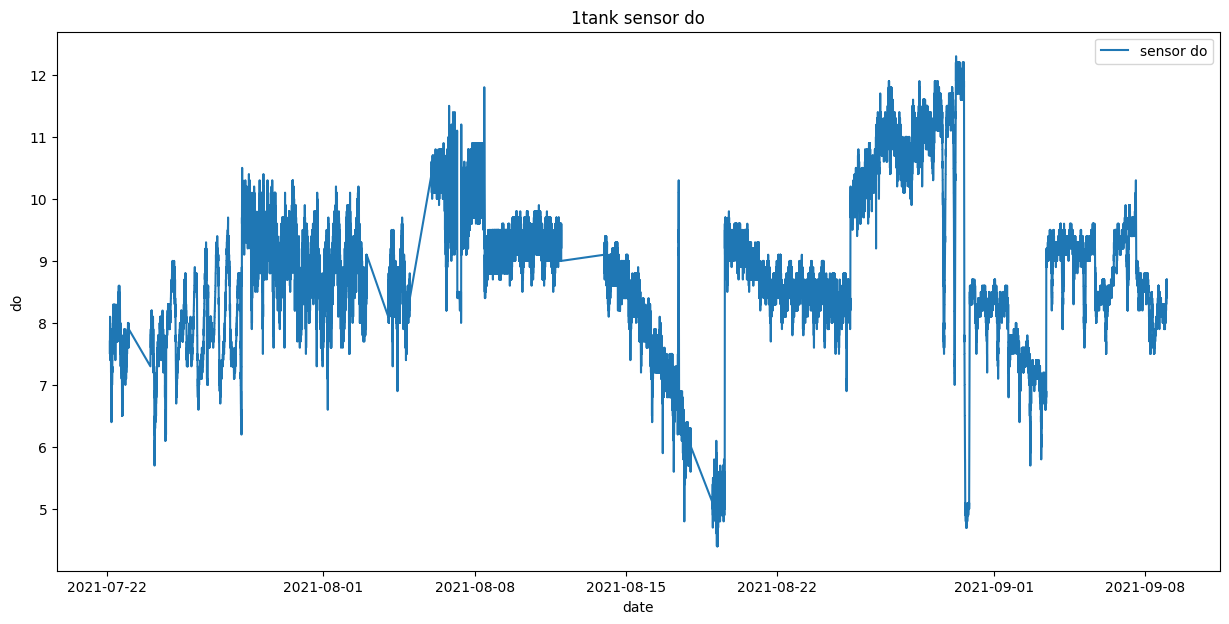

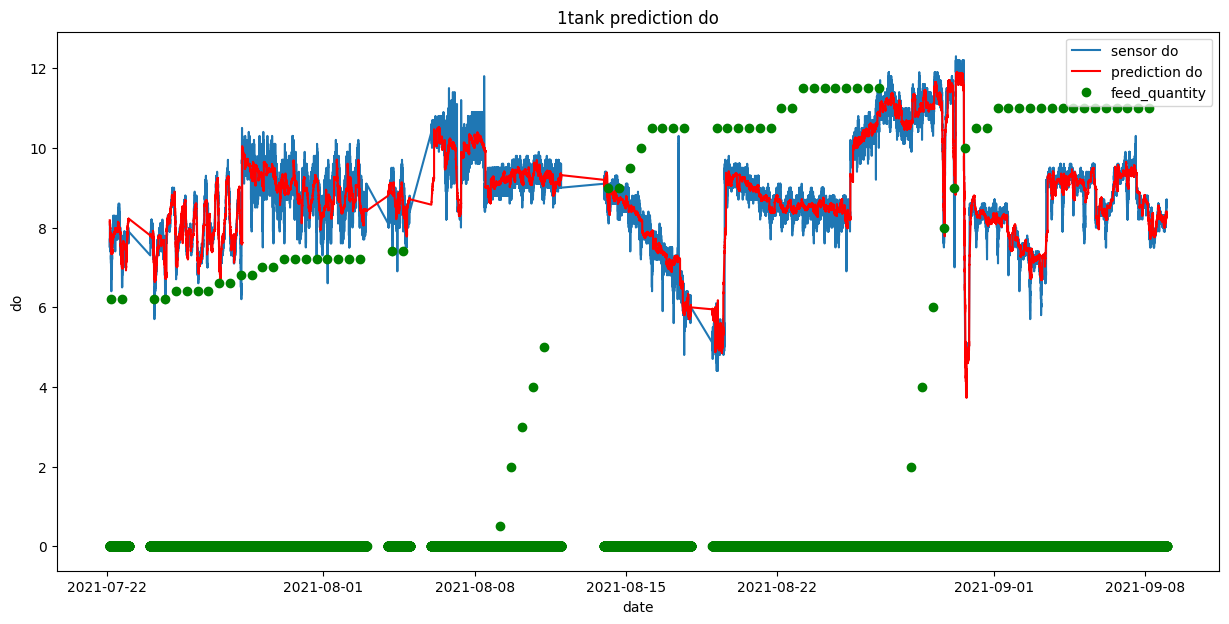

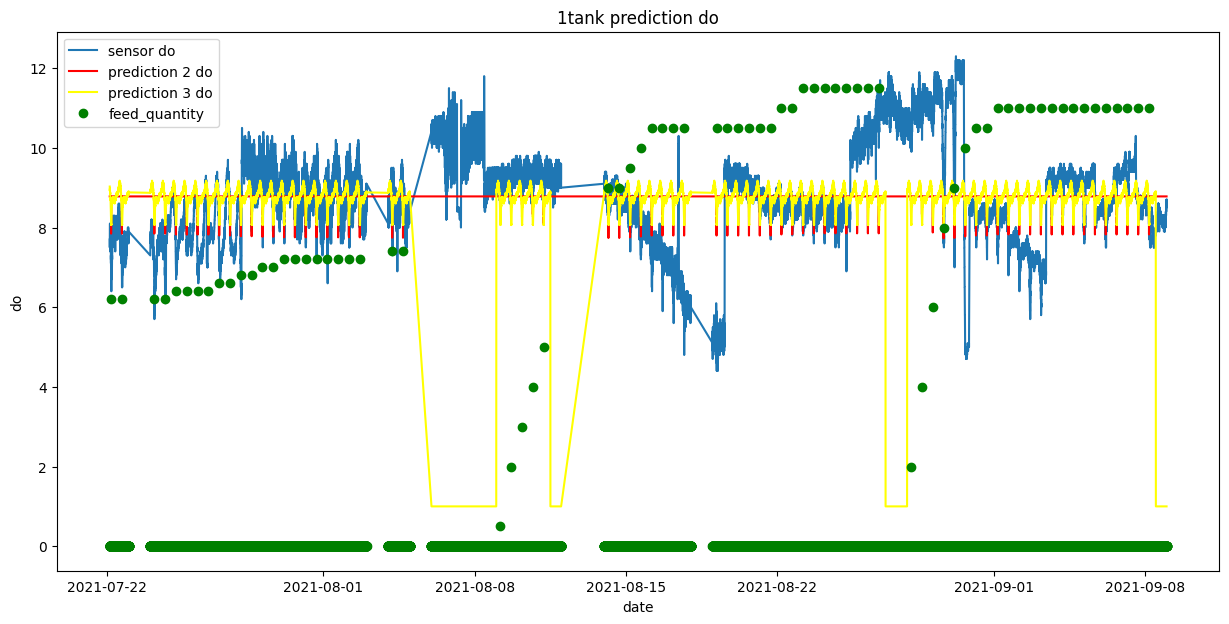

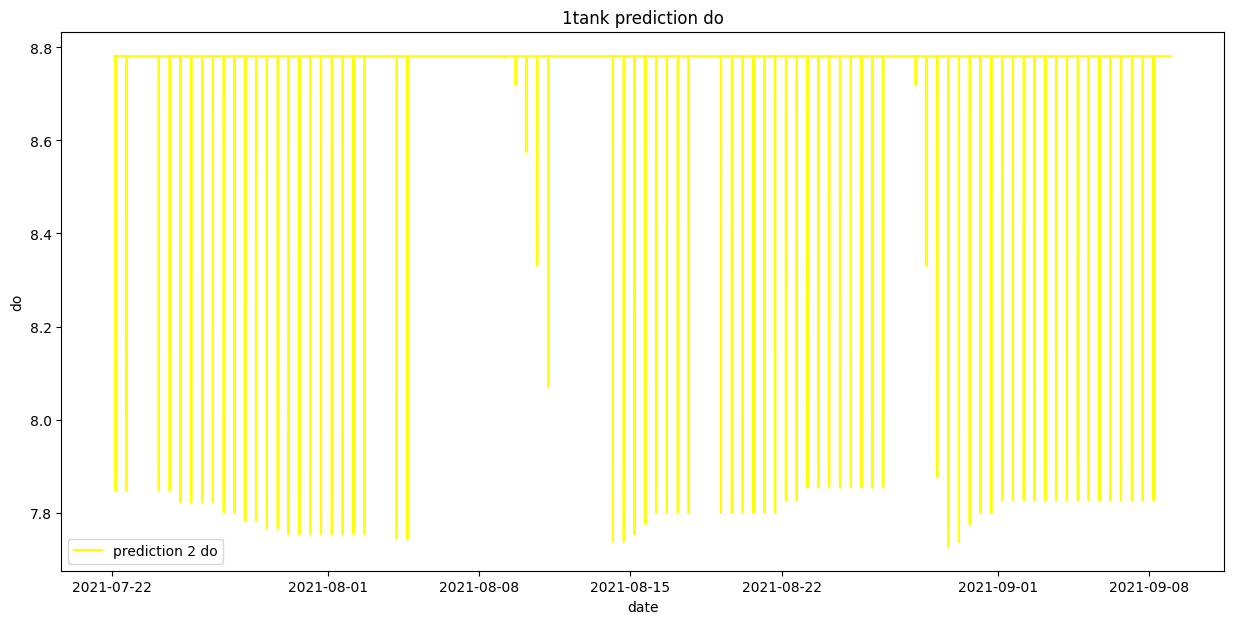

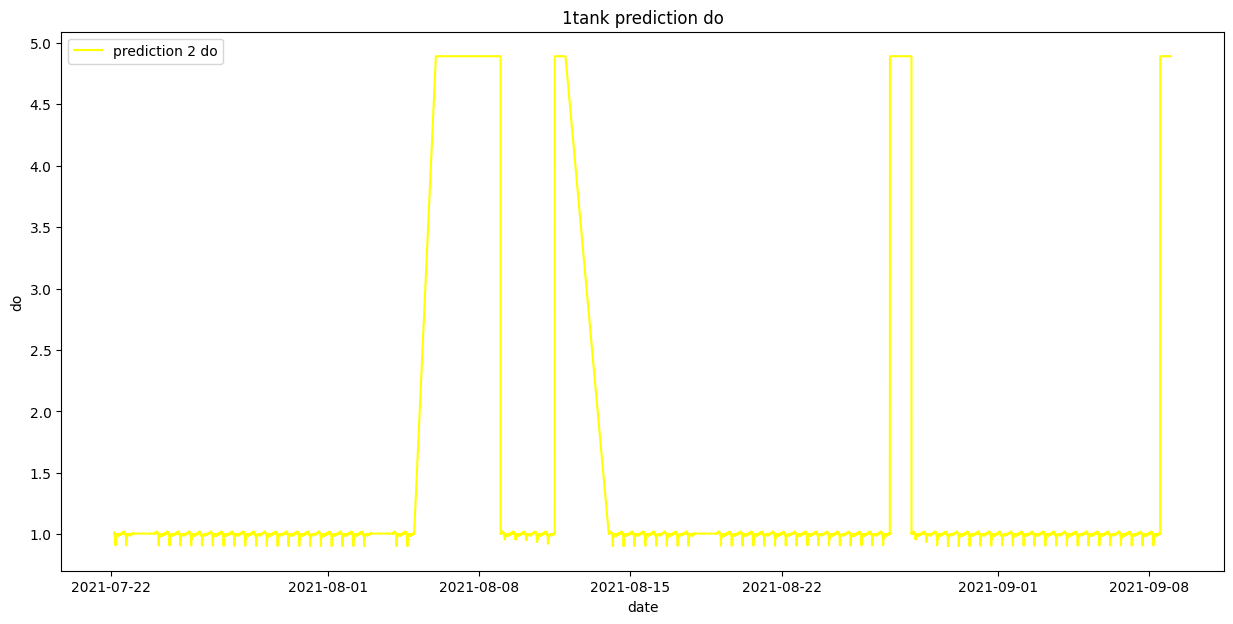

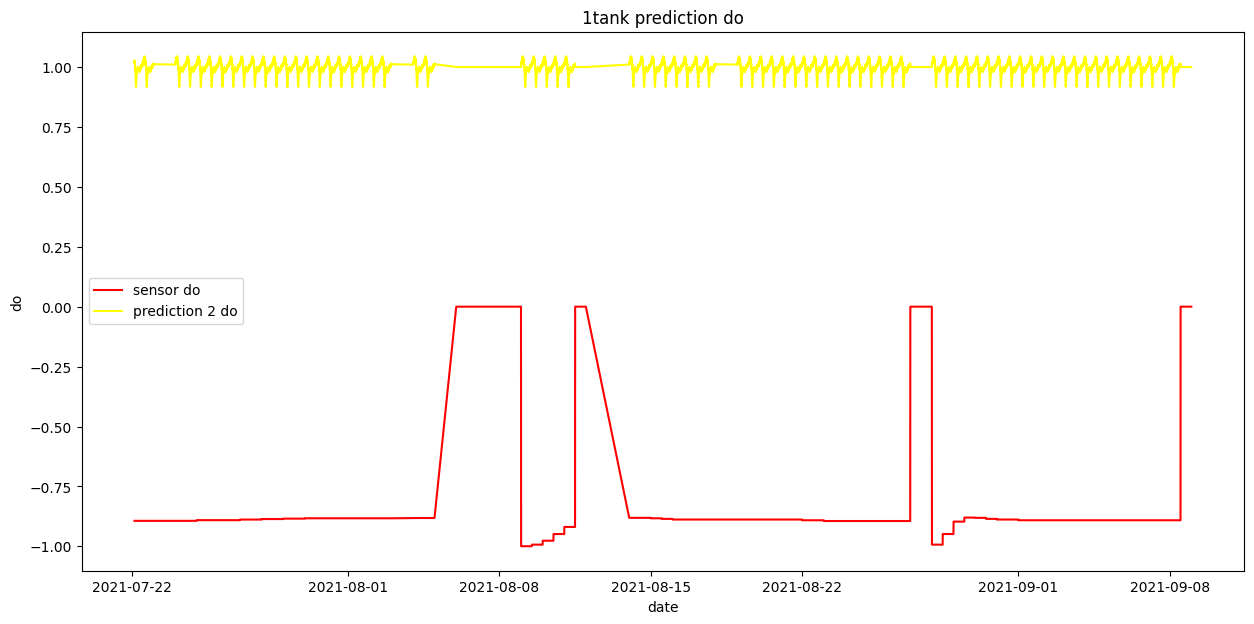

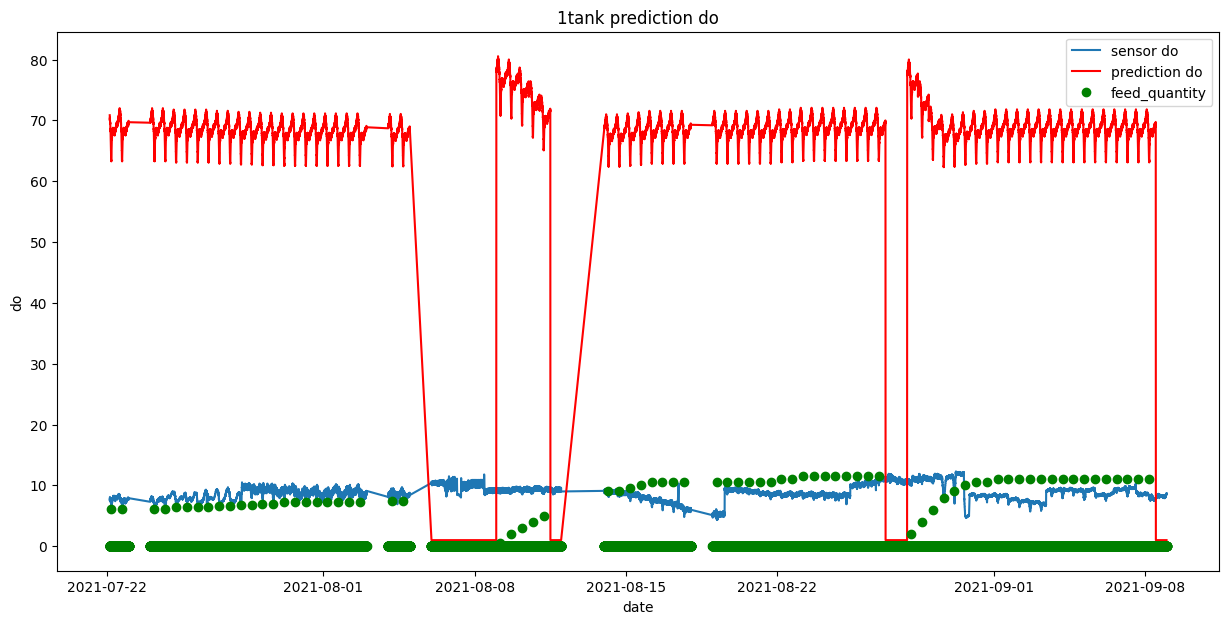

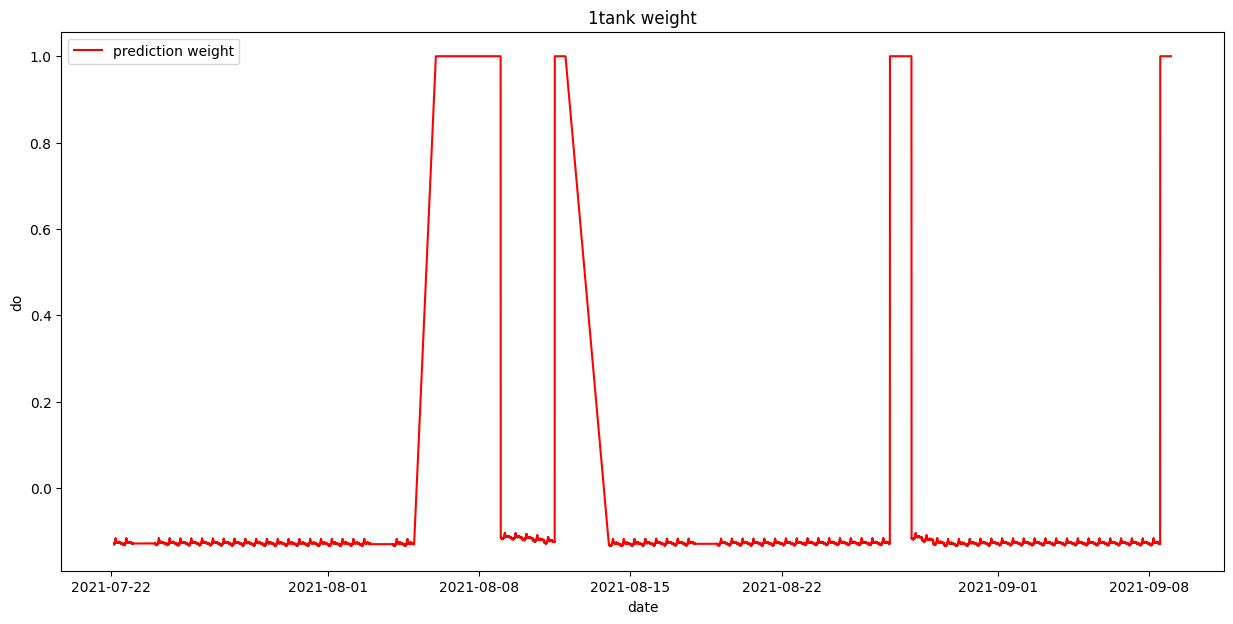

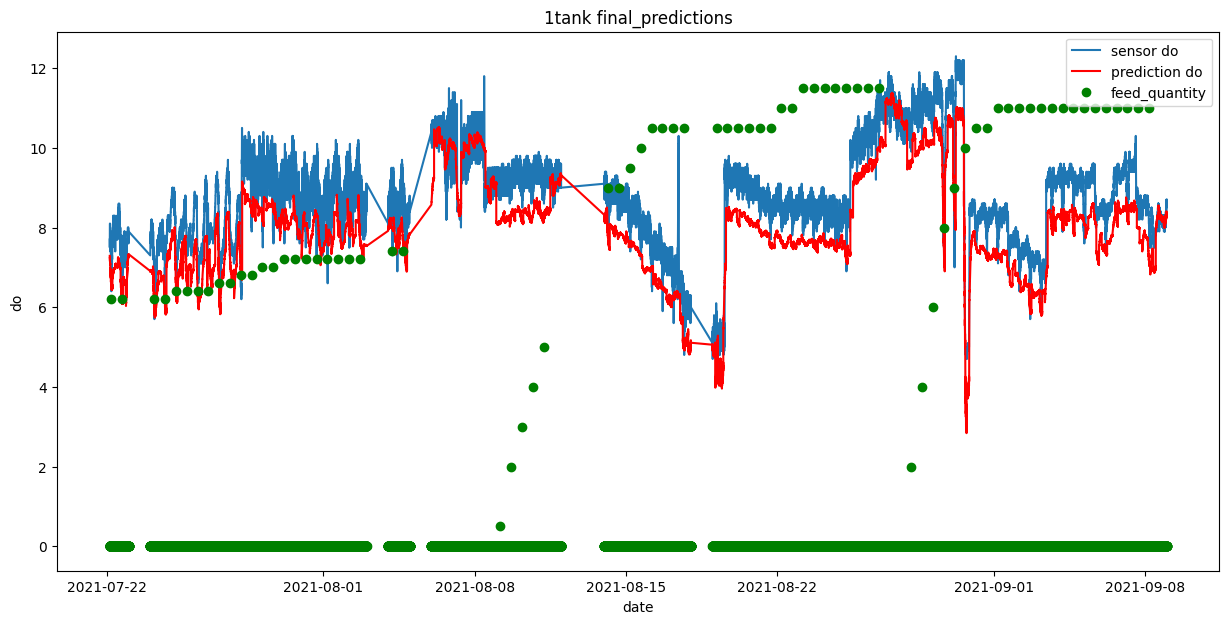

Euclidean Distance
 90.16424024300555  →  225.86714727057094
Cosine Similarity
 0.999166663562476  →  0.9984121173226794
Correlation Coefficient
 0.044795493385586416  →  0.06485651732509501
Mean Squared Error
 0.131674606715232  →  0.8263033400736255
Mean Absolute Error
 0.2532558635704565  →  0.8274854263147234
Correlation Coefficient
 0.9552045066144135  →  0.9351434826749057


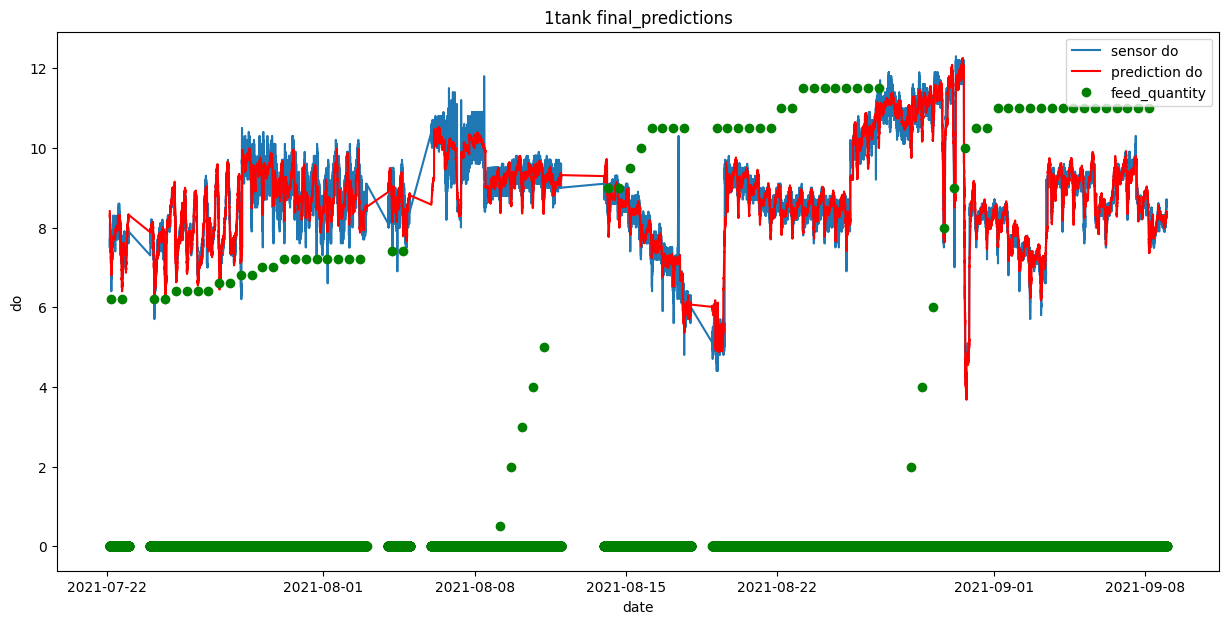

Euclidean Distance
 90.16424024300555  →  90.03540270179236
Cosine Similarity
 0.999166663562476  →  0.9991692197595287
Correlation Coefficient
 0.044795493385586416  →  0.0443696562003405
Mean Squared Error
 0.131674606715232  →  0.13129857045147256
Mean Absolute Error
 0.2532558635704565  →  0.2613787507580485
Correlation Coefficient
 0.9552045066144135  →  0.9556303437996572


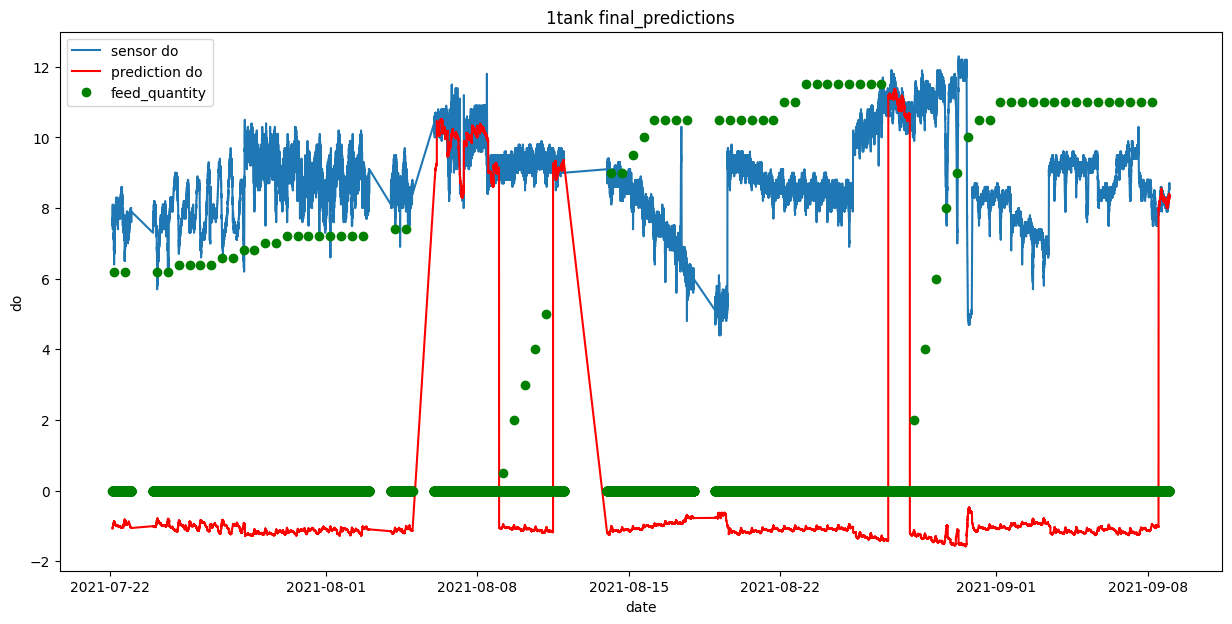

Euclidean Distance
 90.16424024300555  →  2303.472604537909
Cosine Similarity
 0.999166663562476  →  0.0870060449230905
Correlation Coefficient
 0.044795493385586416  →  0.7123443082436436
Mean Squared Error
 0.131674606715232  →  85.94081697208674
Mean Absolute Error
 0.2532558635704565  →  8.667493151087756
Correlation Coefficient
 0.9552045066144135  →  0.28765569175635586


In [246]:
grapeNEva5(y_test, X_test_reshape1, feed)

nCar: 1260 nVar: 1
nCar: 7 nVar: 9
nCar: 7 nVar: 9
1/1 [==============================] - 0s 98ms/step


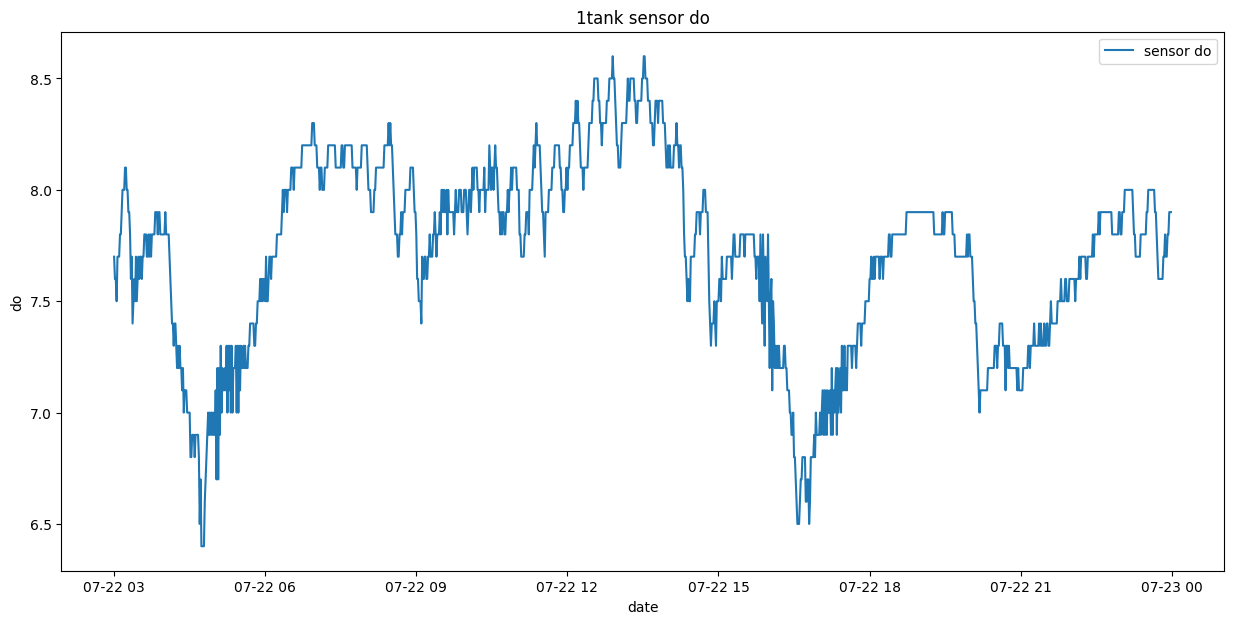

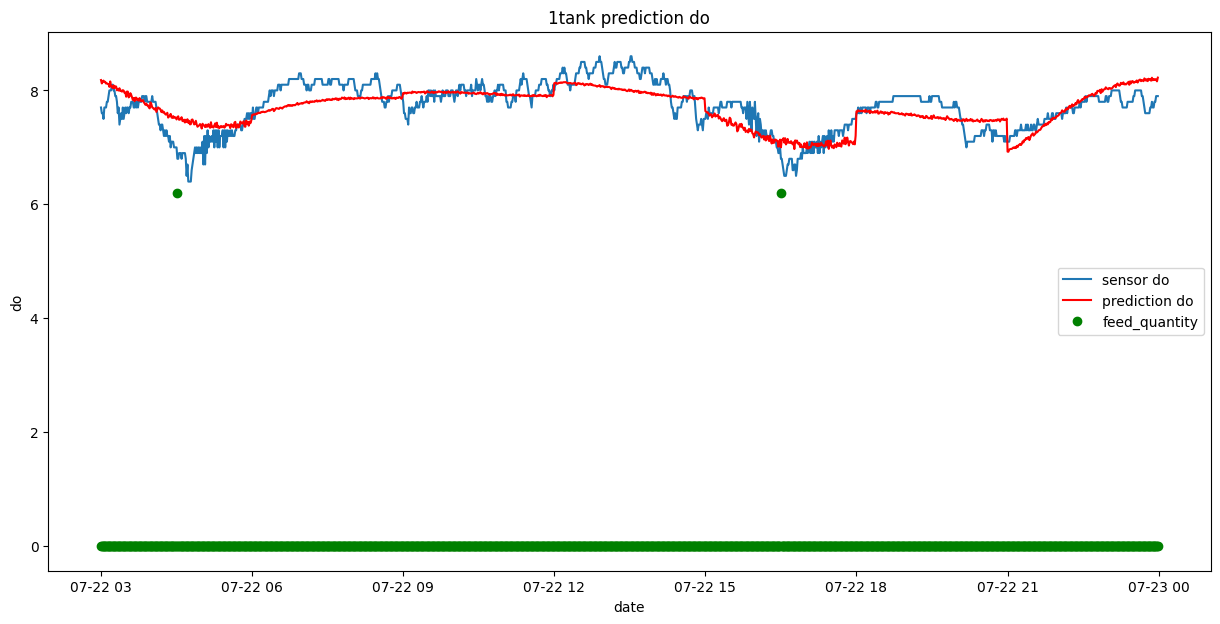

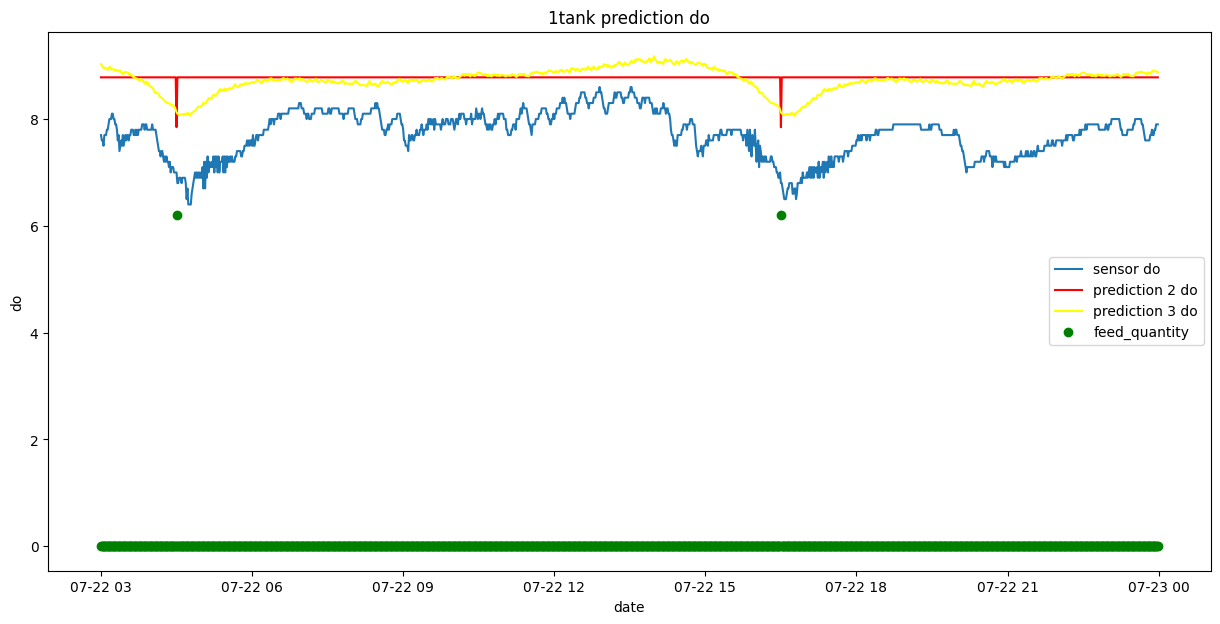

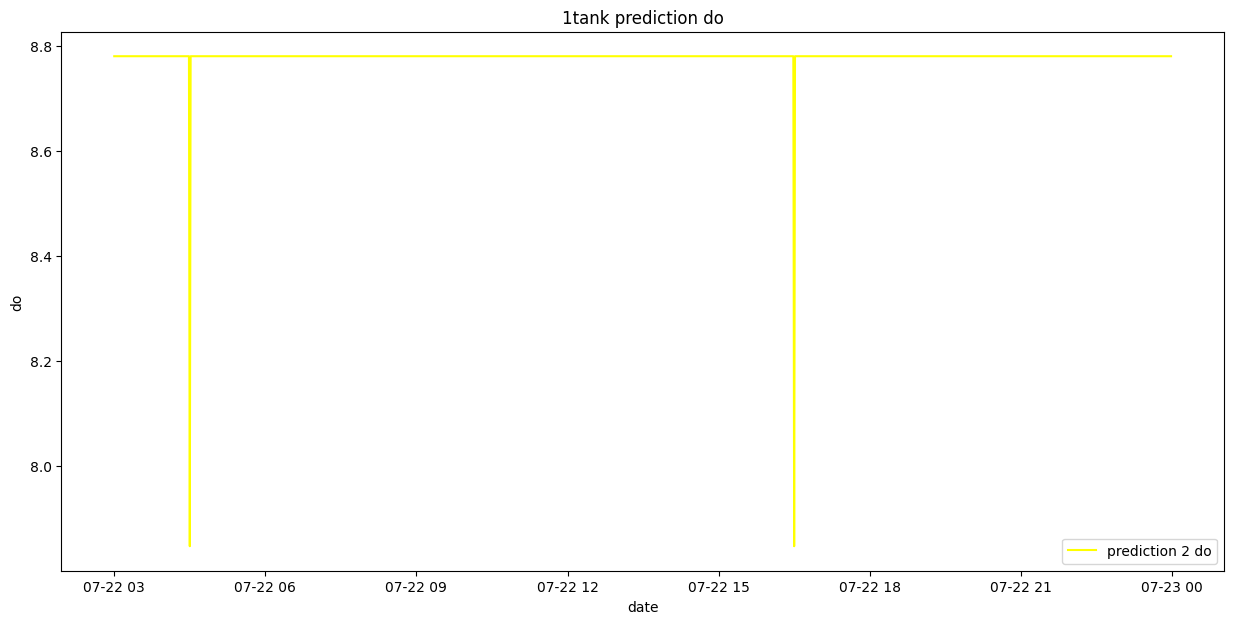

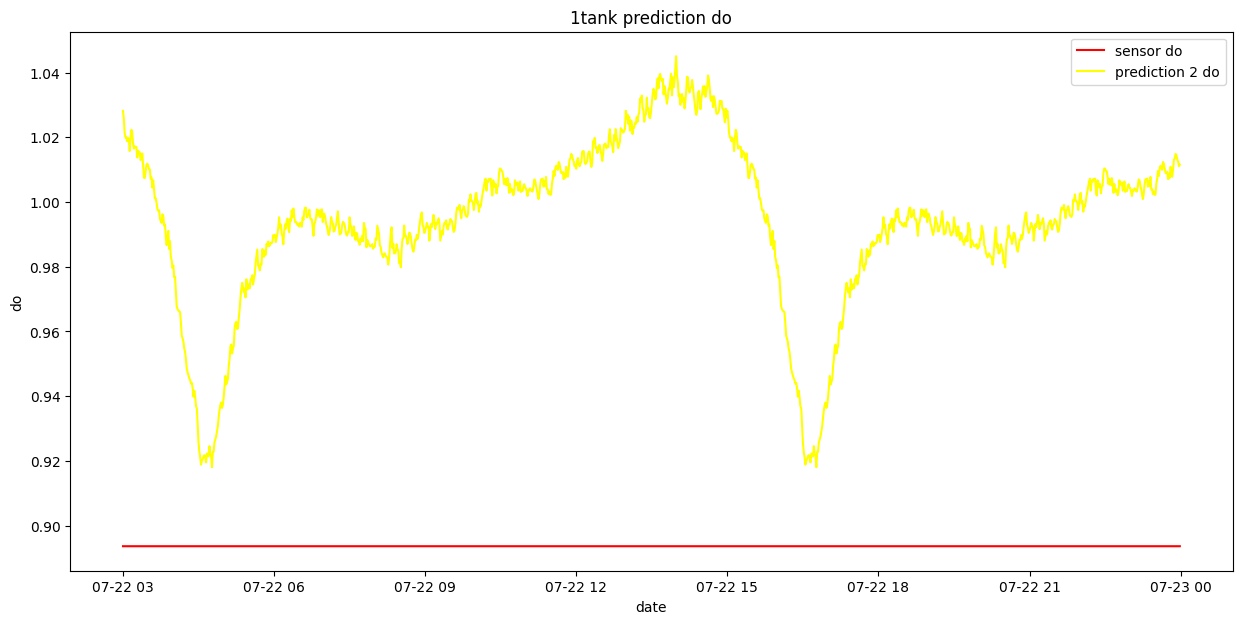

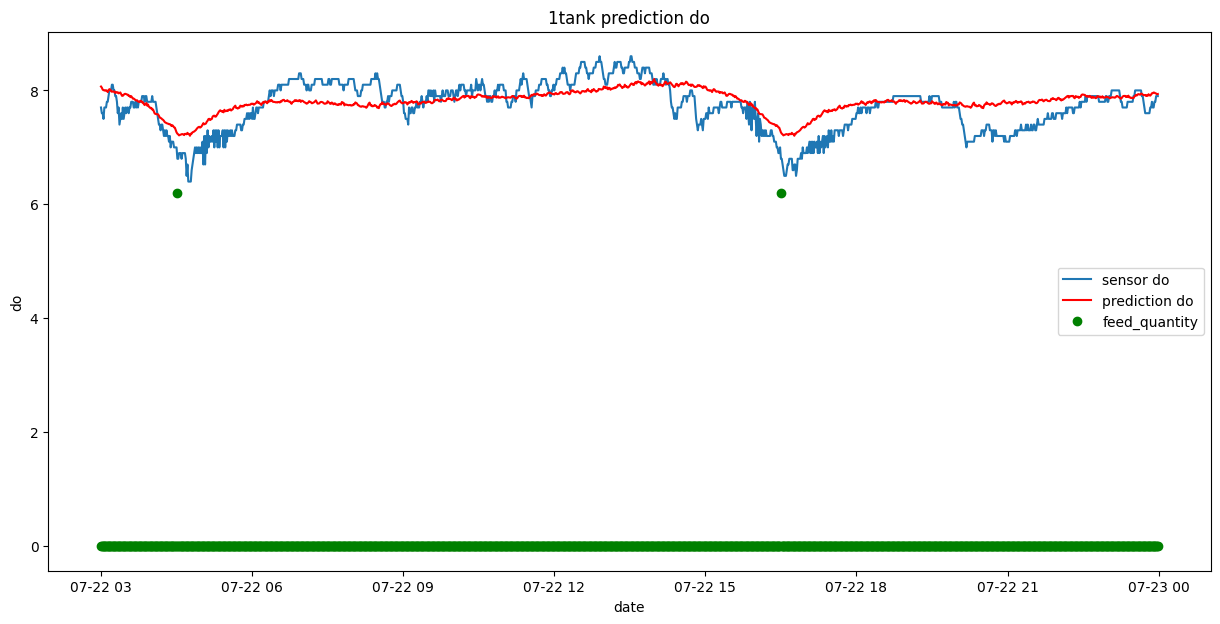

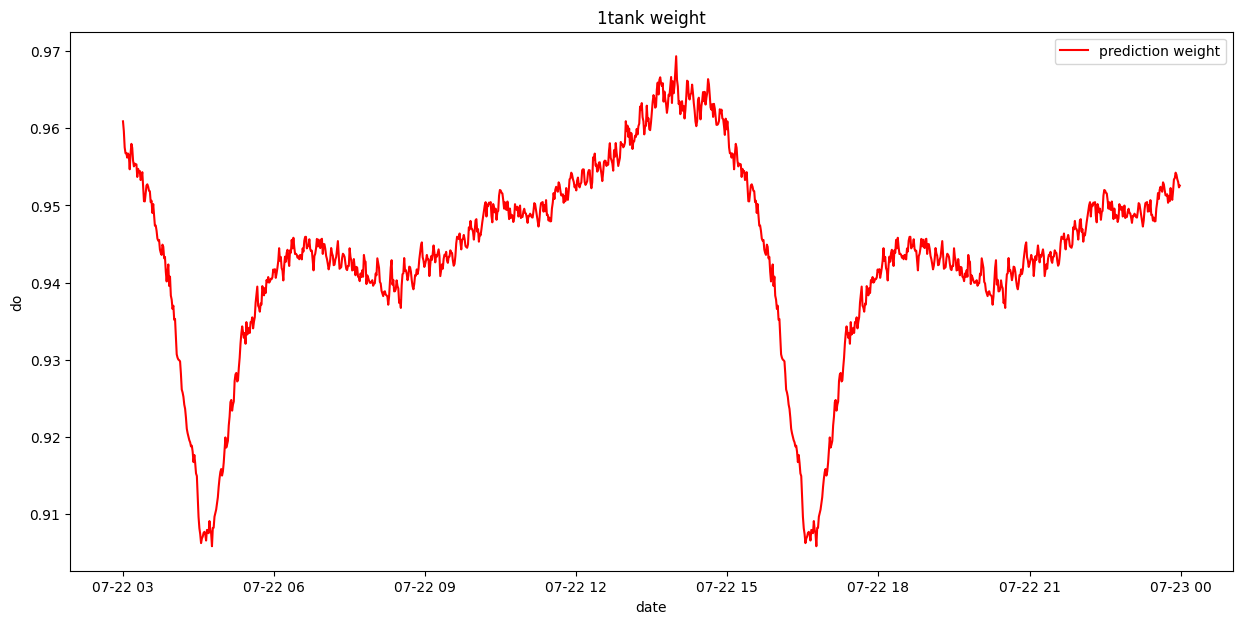

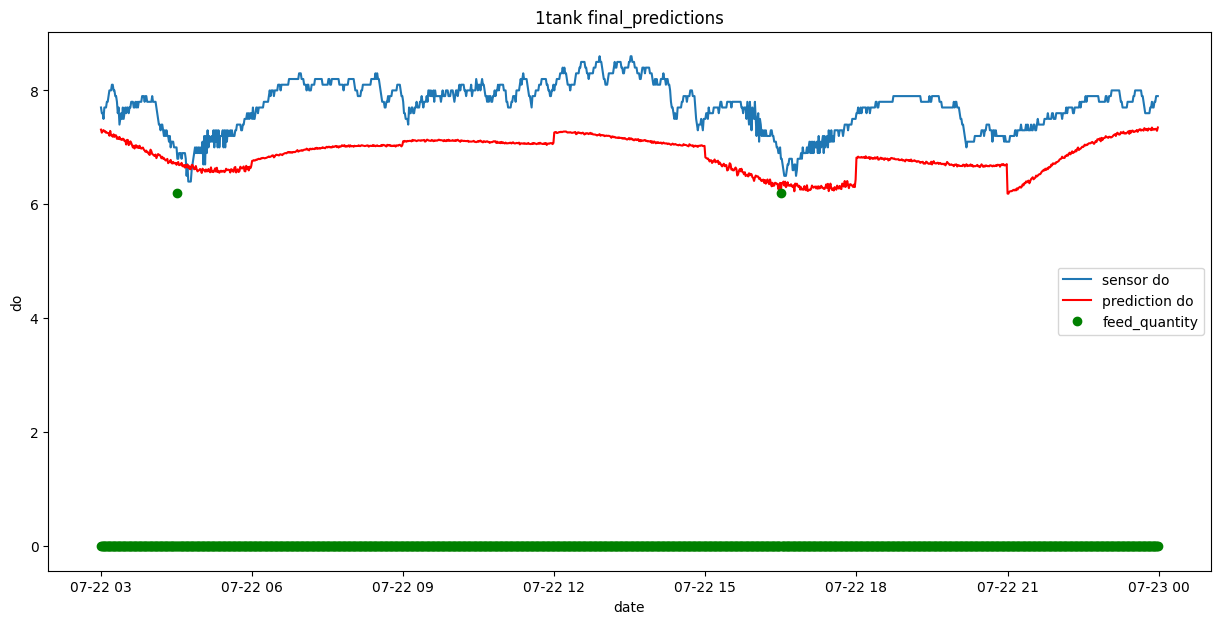

Euclidean Distance
 9.898096117393607  →  31.795529976810045
Cosine Similarity
 0.9993591835979728  →  0.9993591835979727
Correlation Coefficient
 0.2437354619309552  →  0.2437354619309553
Mean Squared Error
 0.07775579900727178  →  0.8023458146874811
Mean Absolute Error
 0.22756991848113042  →  0.8531361266756853
Correlation Coefficient
 0.7562645380690448  →  0.7562645380690446


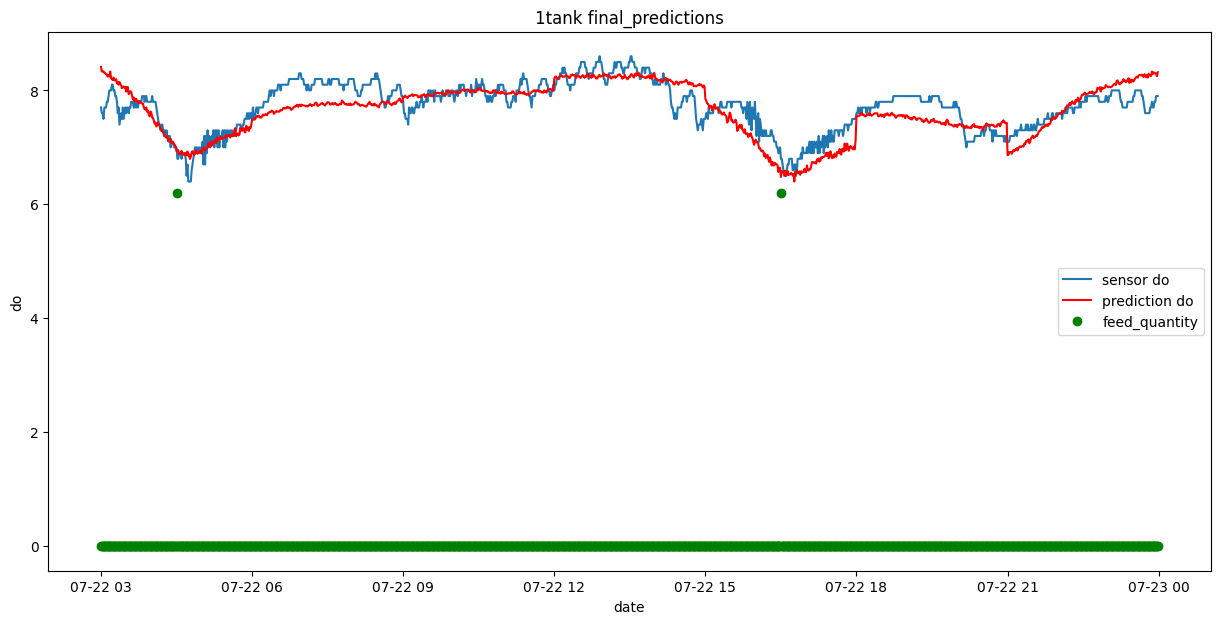

Euclidean Distance
 9.898096117393607  →  9.877481221307928
Cosine Similarity
 0.9993591835979728  →  0.9993910808765785
Correlation Coefficient
 0.2437354619309552  →  0.17941208716047197
Mean Squared Error
 0.07775579900727178  →  0.07743225022007201
Mean Absolute Error
 0.22756991848113042  →  0.22672380124847488
Correlation Coefficient
 0.7562645380690448  →  0.8205879128395281


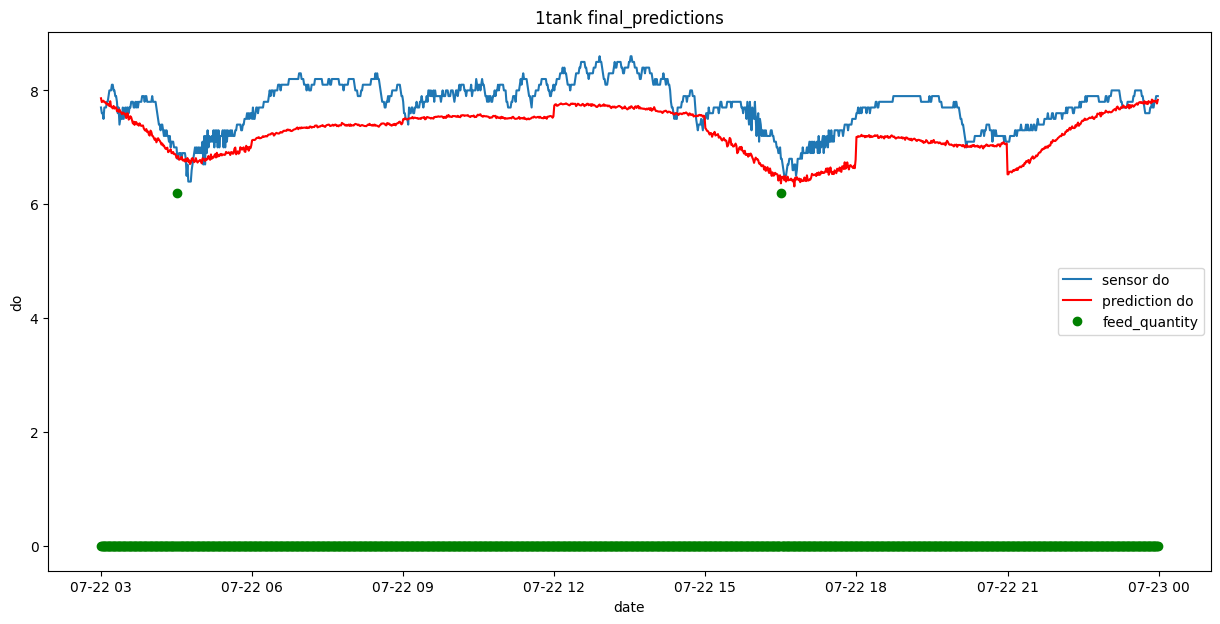

Euclidean Distance
 9.898096117393607  →  18.729010024883493
Cosine Similarity
 0.9993591835979728  →  0.9994488804161252
Correlation Coefficient
 0.2437354619309552  →  0.1950803193219922
Mean Squared Error
 0.07775579900727178  →  0.27839350516840183
Mean Absolute Error
 0.22756991848113042  →  0.4754690103908841
Correlation Coefficient
 0.7562645380690448  →  0.804919680678008


In [204]:
y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-07-22 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-07-22 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-22 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

In [113]:
y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-07-31 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-07-31 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-31 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

nCar: 12780 nVar: 1


ValueError: cannot reshape array of size 115020 into shape (180,8)

nCar: 7020 nVar: 1
nCar: 39 nVar: 8
nCar: 39 nVar: 8
1/1 [==============================] - 0s 101ms/step


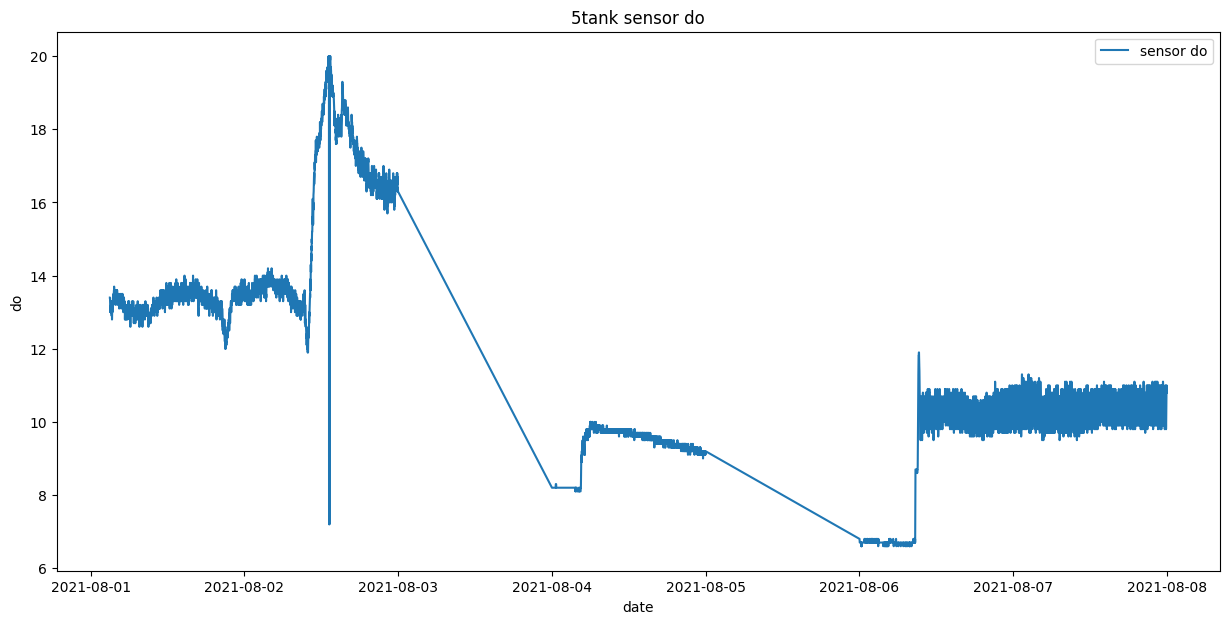

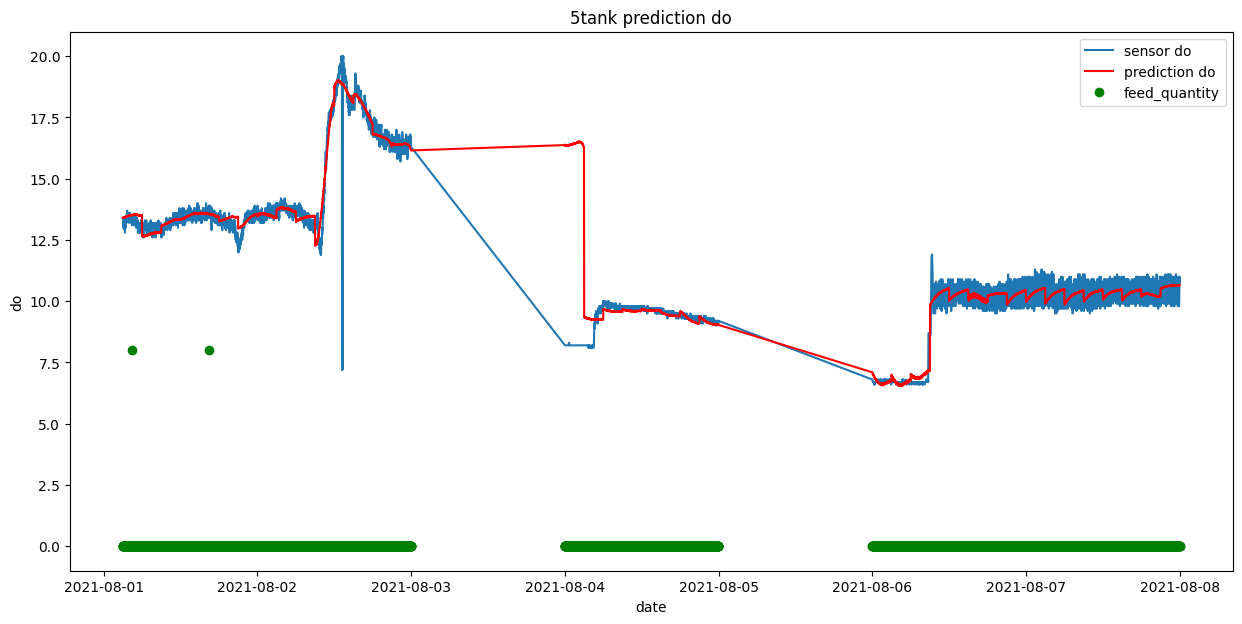

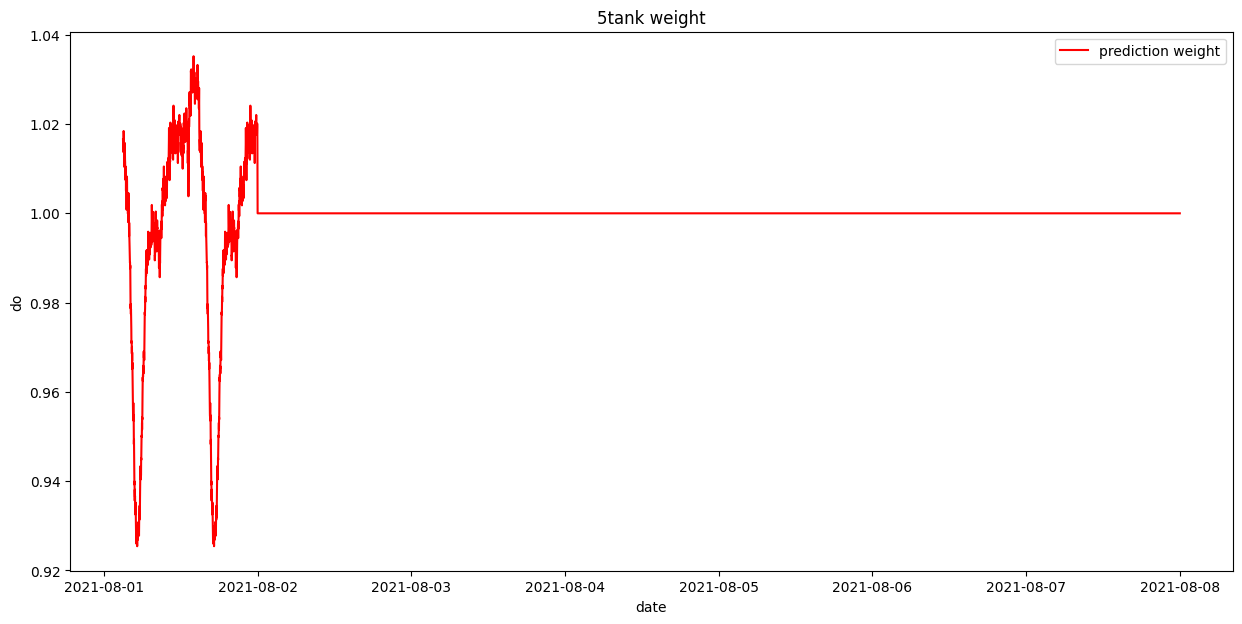

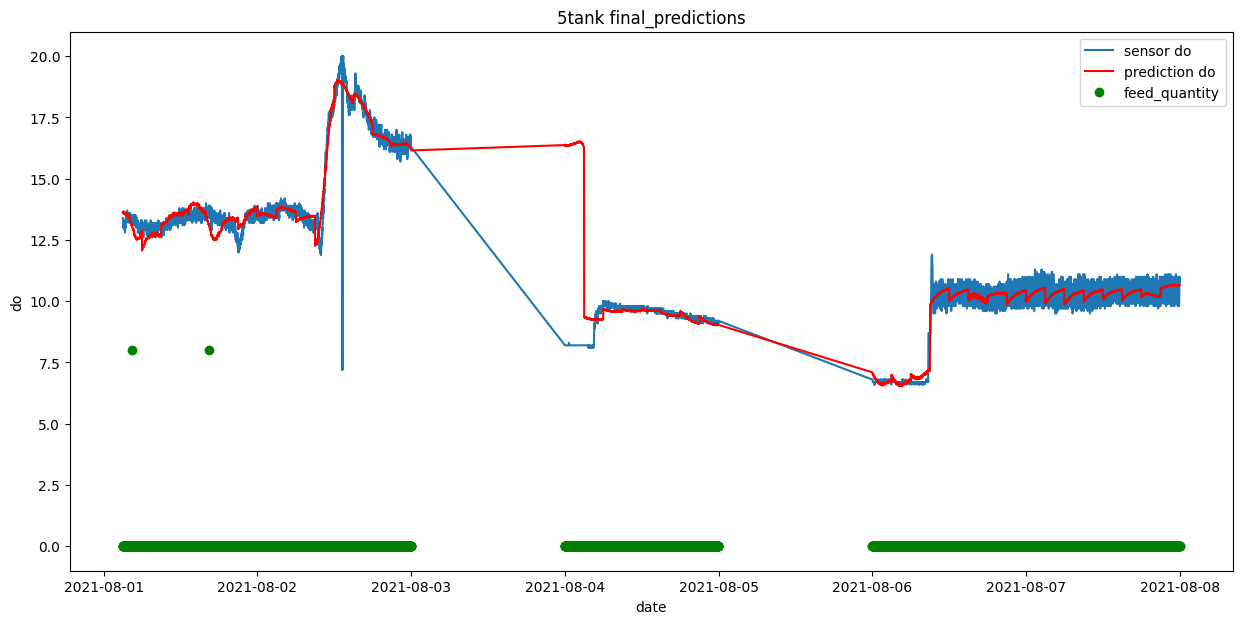

Euclidean Distance
 115.65143857784633  →  116.18287761723825
Cosine Similarity
 0.9934704299300763  →  0.9933822409250627
Correlation Coefficient
 0.1089724568711744  →  0.11043866347629006
Mean Squared Error
 1.9053070149751243  →  1.9228576996327877
Mean Absolute Error
 0.47979851236370546  →  0.5029806303083175
Correlation Coefficient
 0.8910275431288259  →  0.8895613365237097


In [76]:
y_date = japonica_validation_features_y.loc['2021-08-01 03:00':'2021-08-07 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )
1
X_test1 = japonica_validation_features_X_a.loc['2021-08-01 00:00':'2021-08-07 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-08-01 03:00':'2021-08-07 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

nCar: 8460 nVar: 1
nCar: 47 nVar: 8
nCar: 47 nVar: 8
1/1 [==============================] - 0s 102ms/step


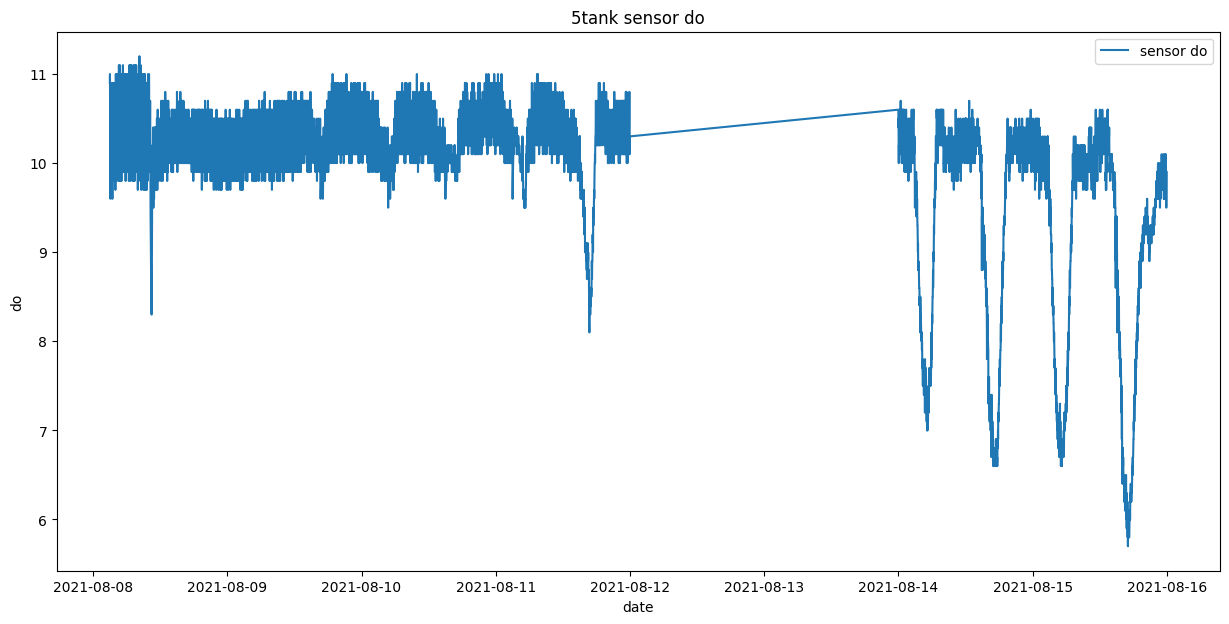

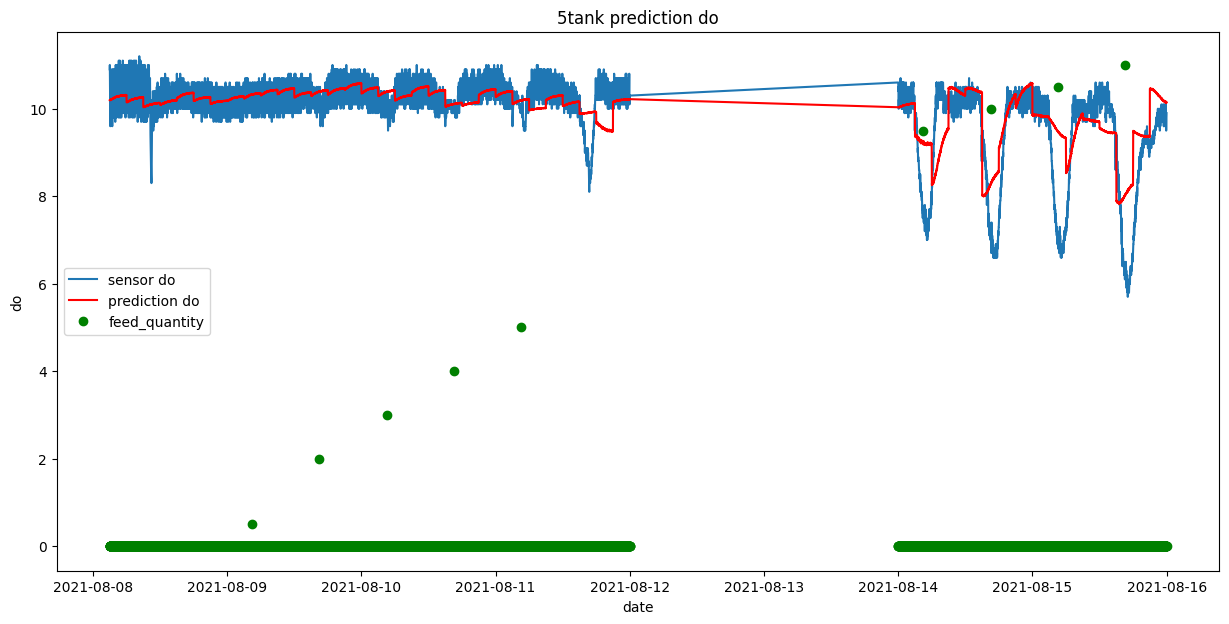

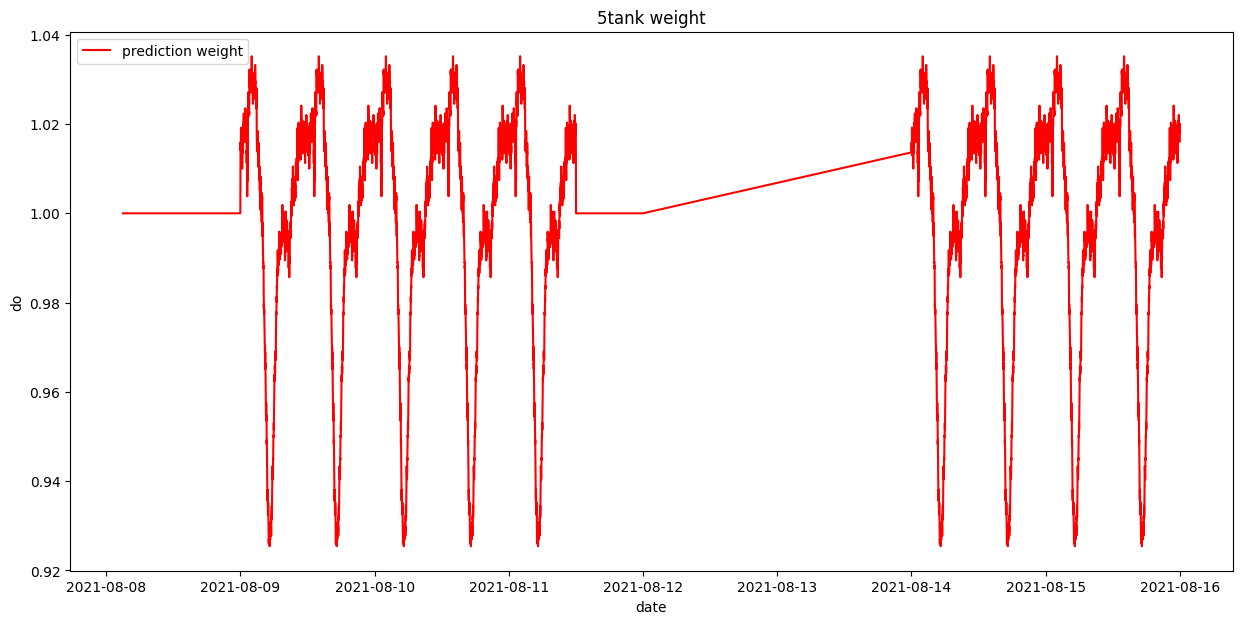

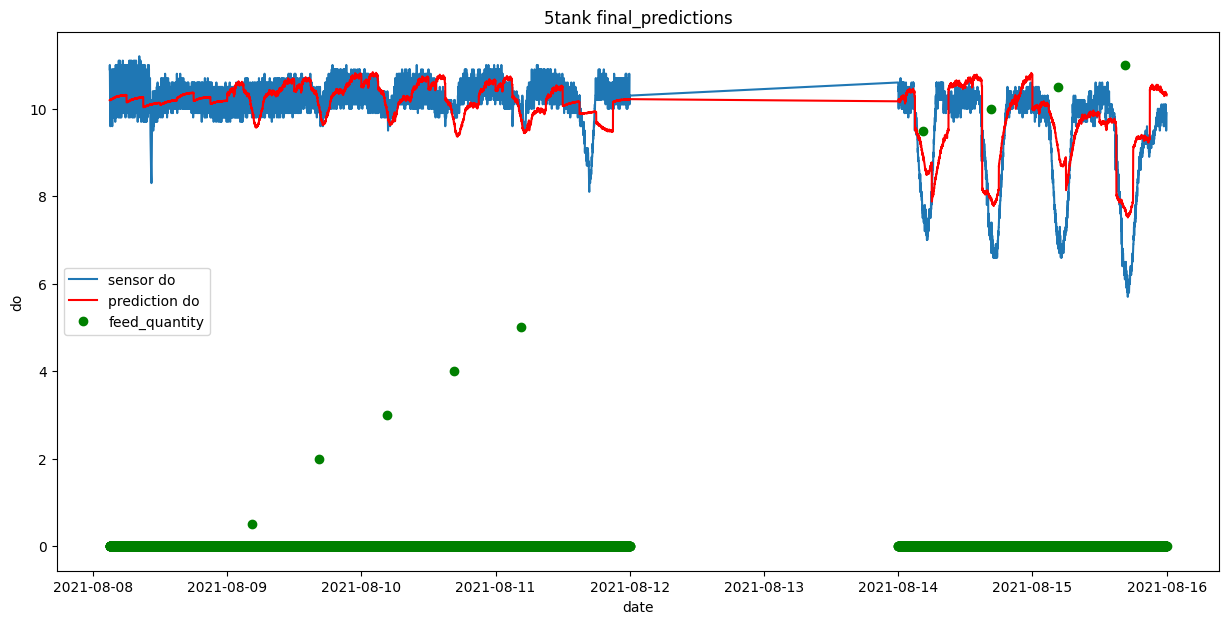

Euclidean Distance
 59.6363067856606  →  55.00302071527528
Cosine Similarity
 0.9979142996197378  →  0.9982257416382416
Correlation Coefficient
 0.2700451307701649  →  0.23207504313398097
Mean Squared Error
 0.4203887809732182  →  0.3576042893386528
Mean Absolute Error
 0.43641167072539633  →  0.4408361058639124
Correlation Coefficient
 0.7299548692298353  →  0.7679249568660188


In [77]:
y_date = japonica_validation_features_y.loc['2021-08-08 03:00':'2021-08-15 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )
1
X_test1 = japonica_validation_features_X_a.loc['2021-08-08 00:00':'2021-08-15 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-08-08 03:00':'2021-08-15 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

nCar: 9900 nVar: 1
nCar: 55 nVar: 8
nCar: 55 nVar: 8
1/1 [==============================] - 0s 103ms/step


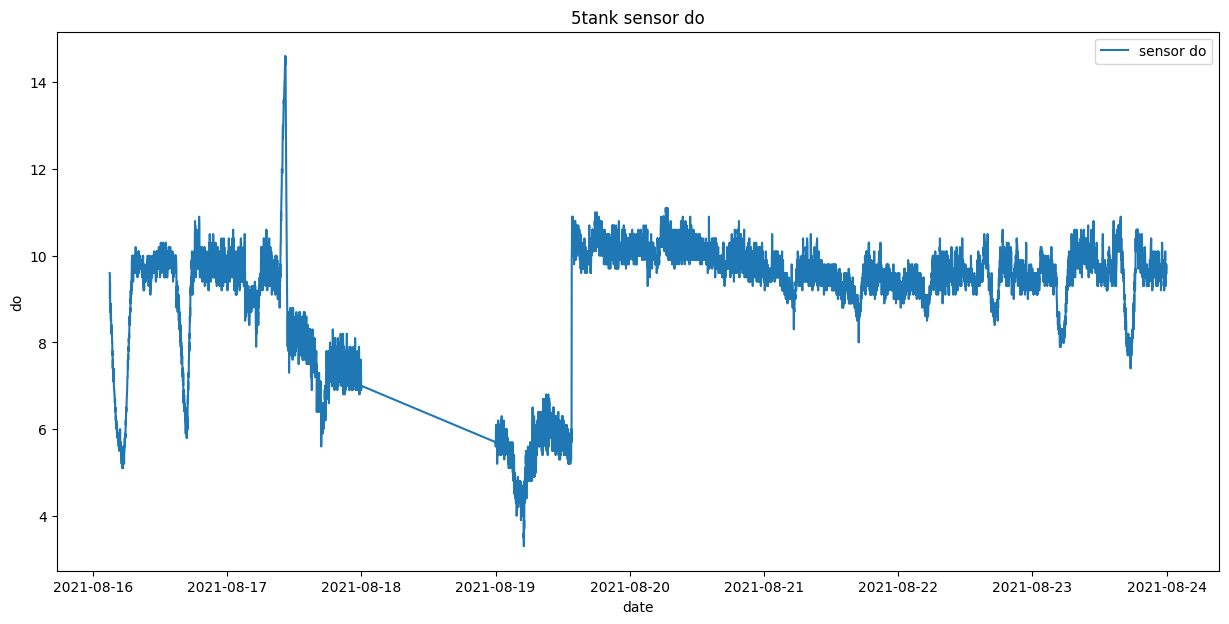

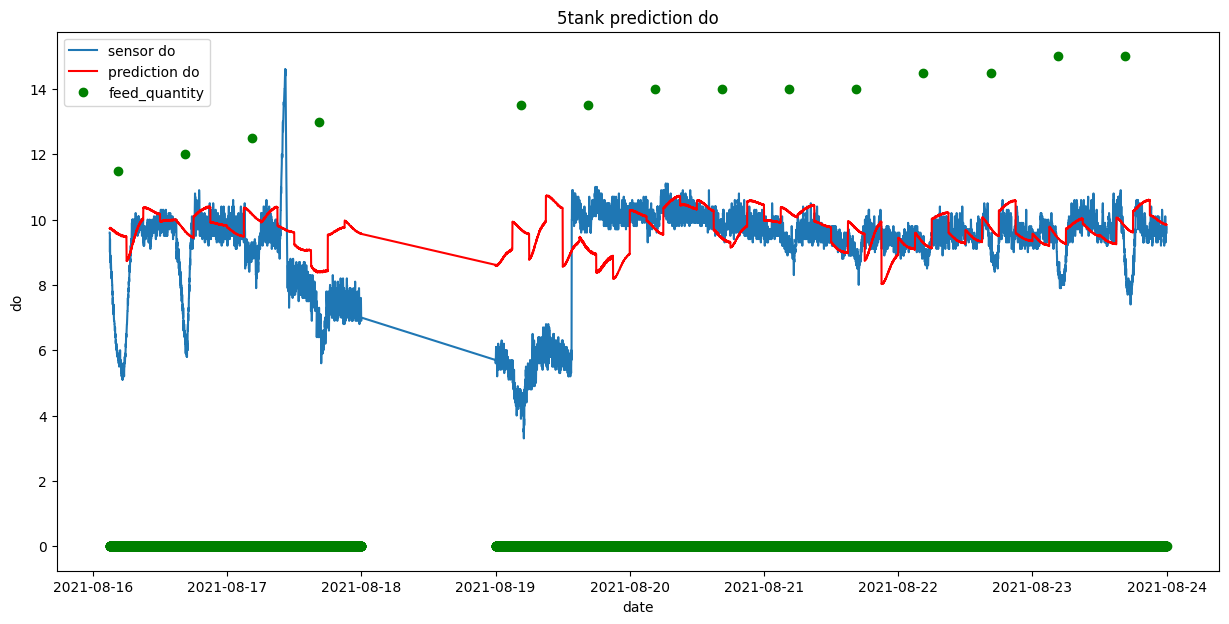

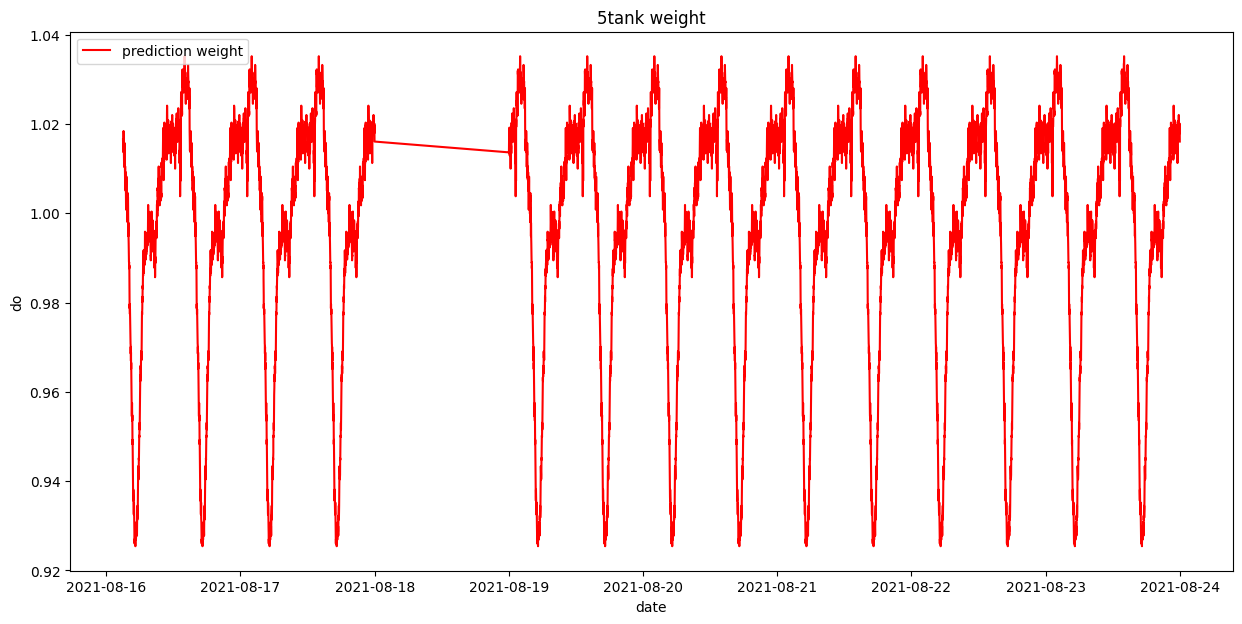

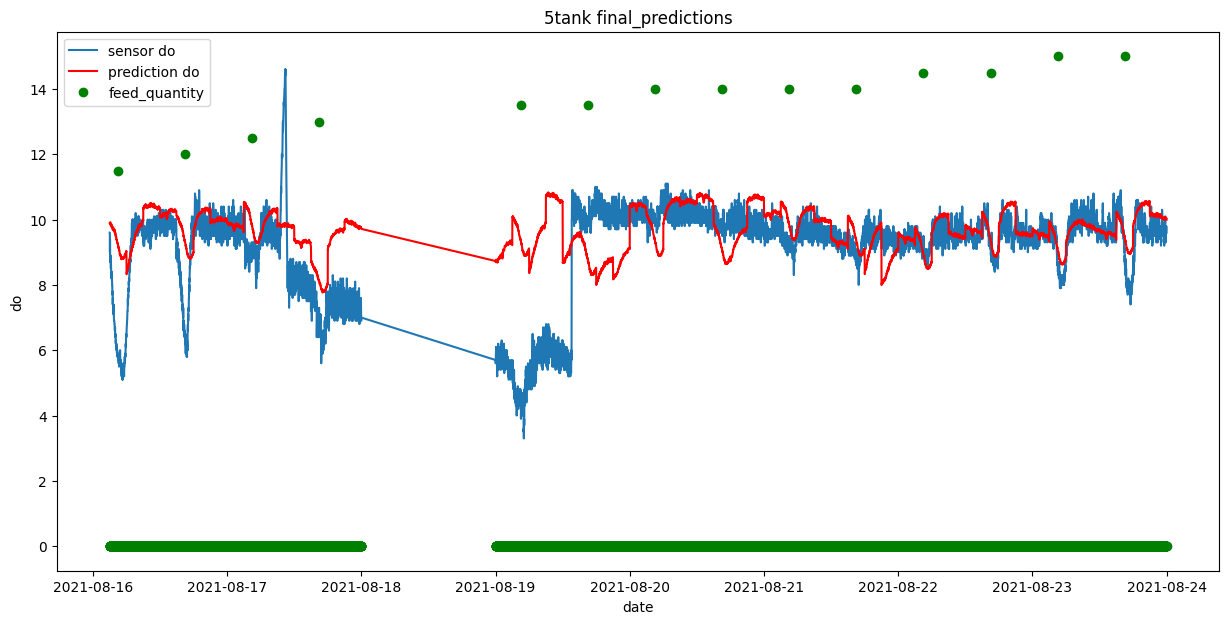

Euclidean Distance
 153.33200419839693  →  150.4789514911191
Cosine Similarity
 0.9879693816925098  →  0.9883491348783726
Correlation Coefficient
 0.7871480937825264  →  0.7300519093587294
Mean Squared Error
 2.3748185365148706  →  2.287264125441067
Mean Absolute Error
 0.9980844387670961  →  0.9787142855857706
Correlation Coefficient
 0.21285190621747352  →  0.26994809064127046


In [78]:
y_date = japonica_validation_features_y.loc['2021-08-16 03:00':'2021-08-23 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-08-16 00:00':'2021-08-23 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-08-16 03:00':'2021-08-23 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

nCar: 11340 nVar: 1
nCar: 63 nVar: 8
nCar: 63 nVar: 8
1/1 [==============================] - 0s 98ms/step


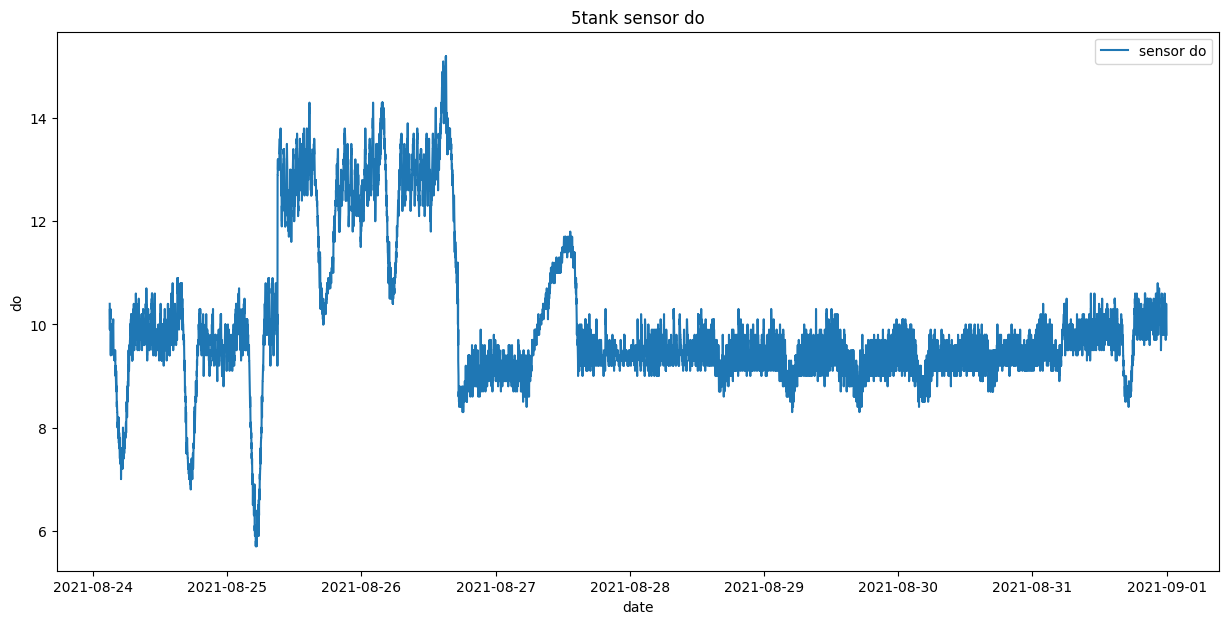

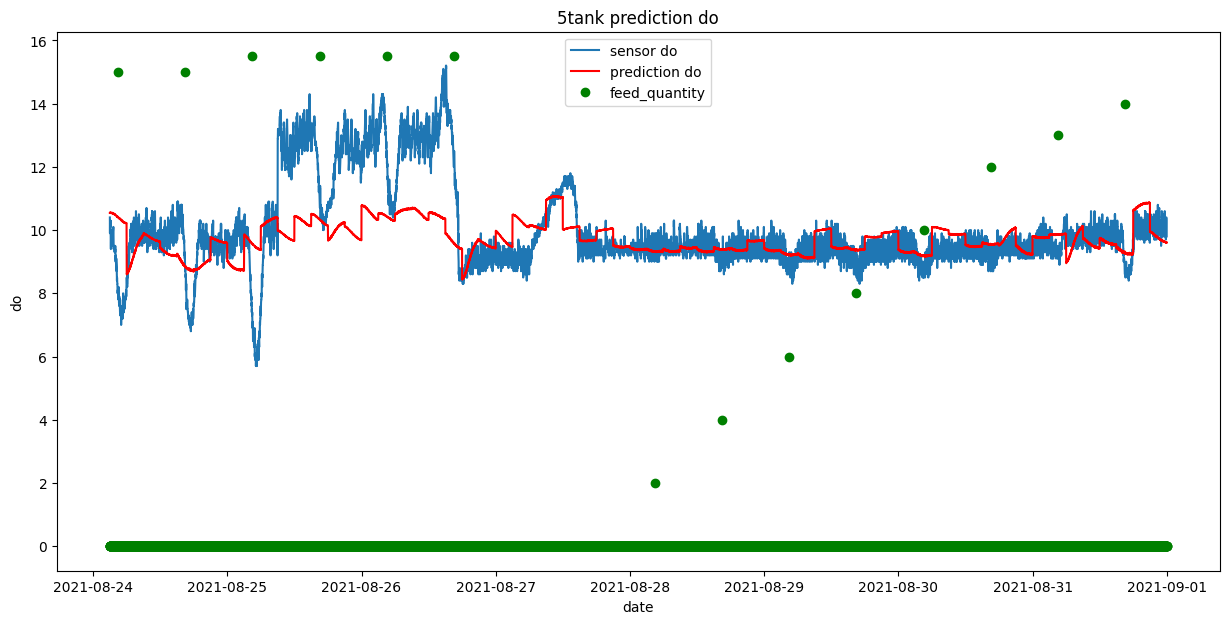

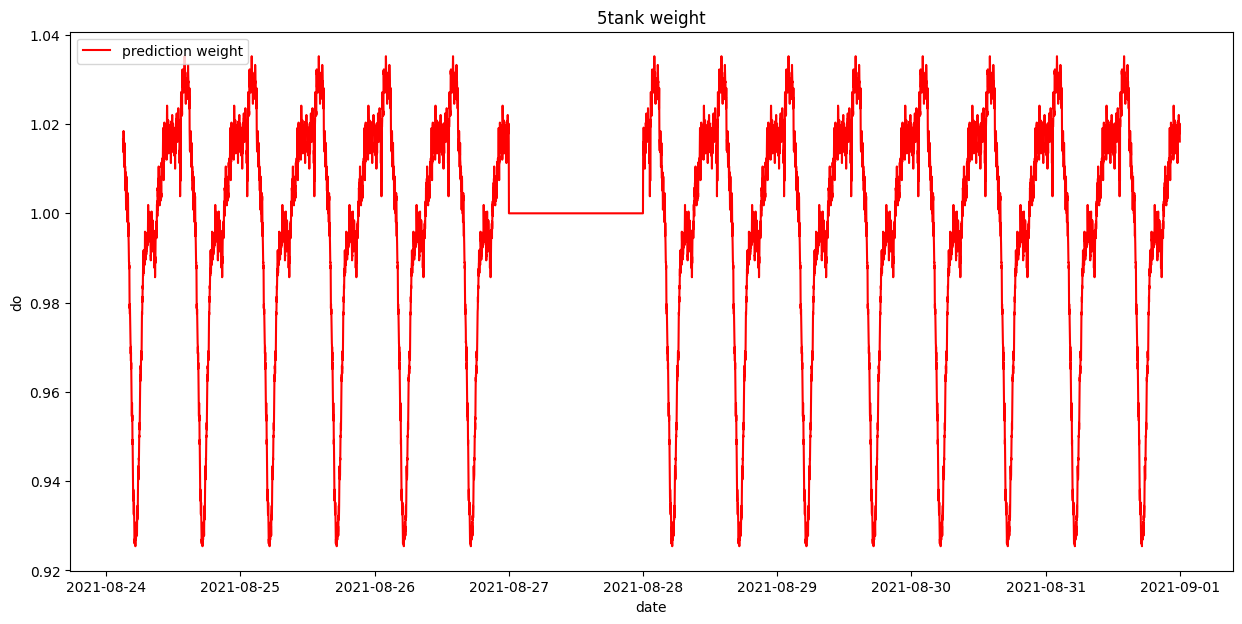

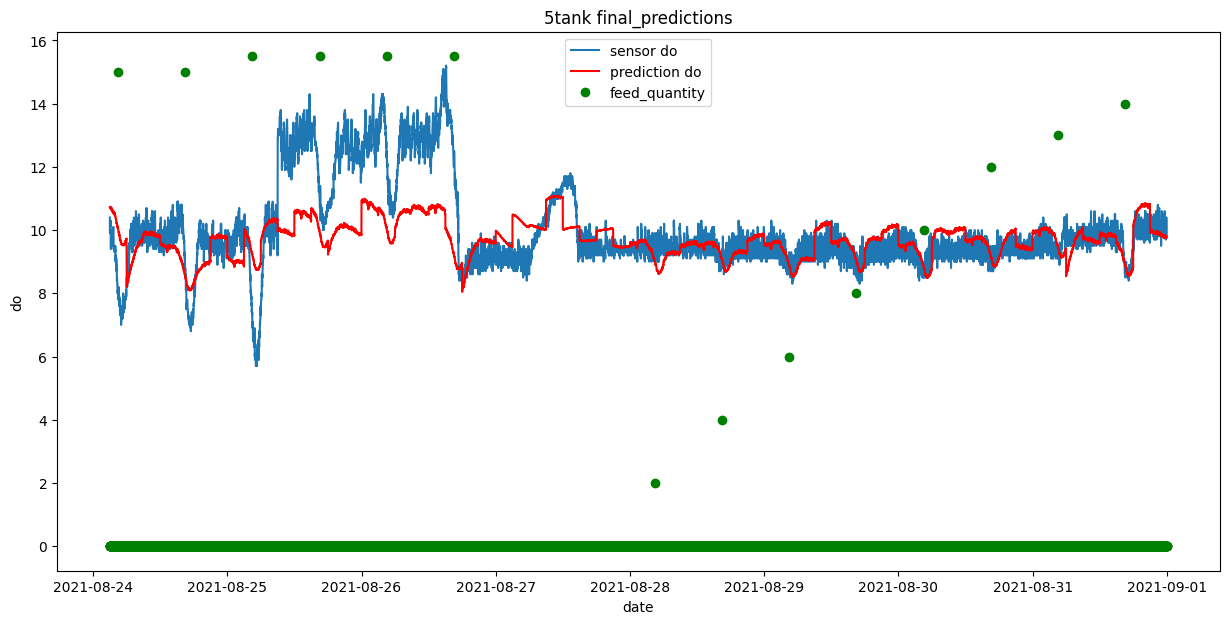

Euclidean Distance
 131.6304103177231  →  126.32508670382657
Cosine Similarity
 0.9929717208229989  →  0.9936310365927695
Correlation Coefficient
 0.46110286452442406  →  0.3983089621794865
Mean Squared Error
 1.527915777814121  →  1.4072334683182826
Mean Absolute Error
 0.8102867422827127  →  0.7944504677942763
Correlation Coefficient
 0.538897135475576  →  0.6016910378205135


In [79]:
y_date = japonica_validation_features_y.loc['2021-08-24 03:00':'2021-08-31 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-08-24 00:00':'2021-08-31 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-08-24 03:00':'2021-08-31 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

nCar: 11340 nVar: 1
nCar: 63 nVar: 8
nCar: 63 nVar: 8
1/1 [==============================] - 0s 101ms/step


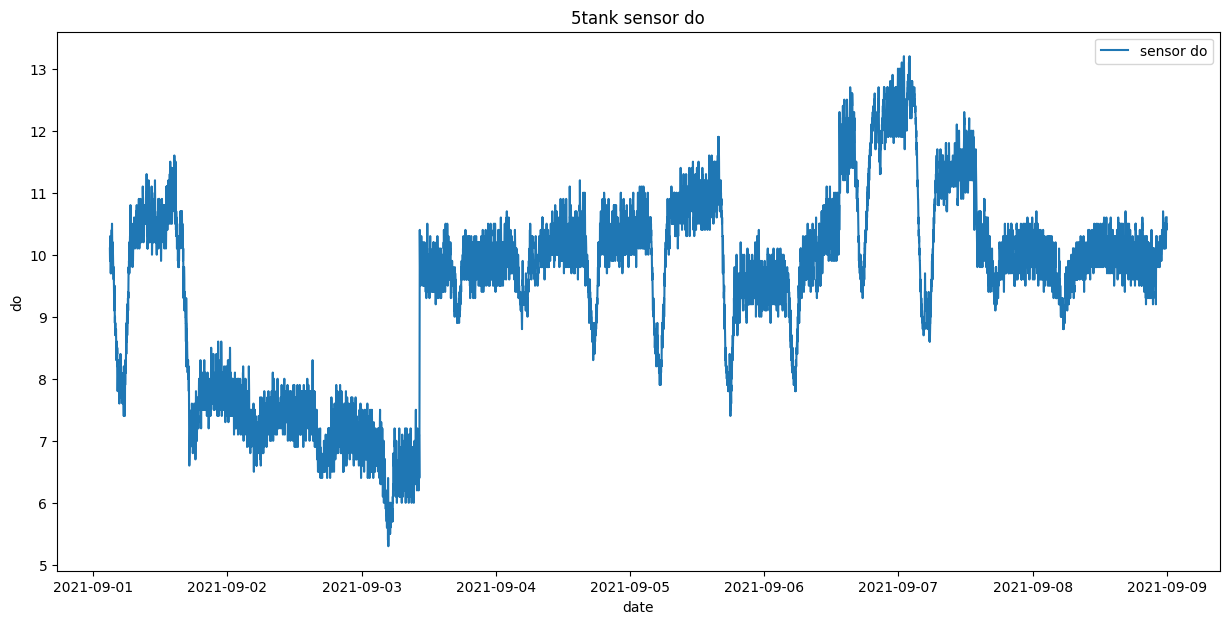

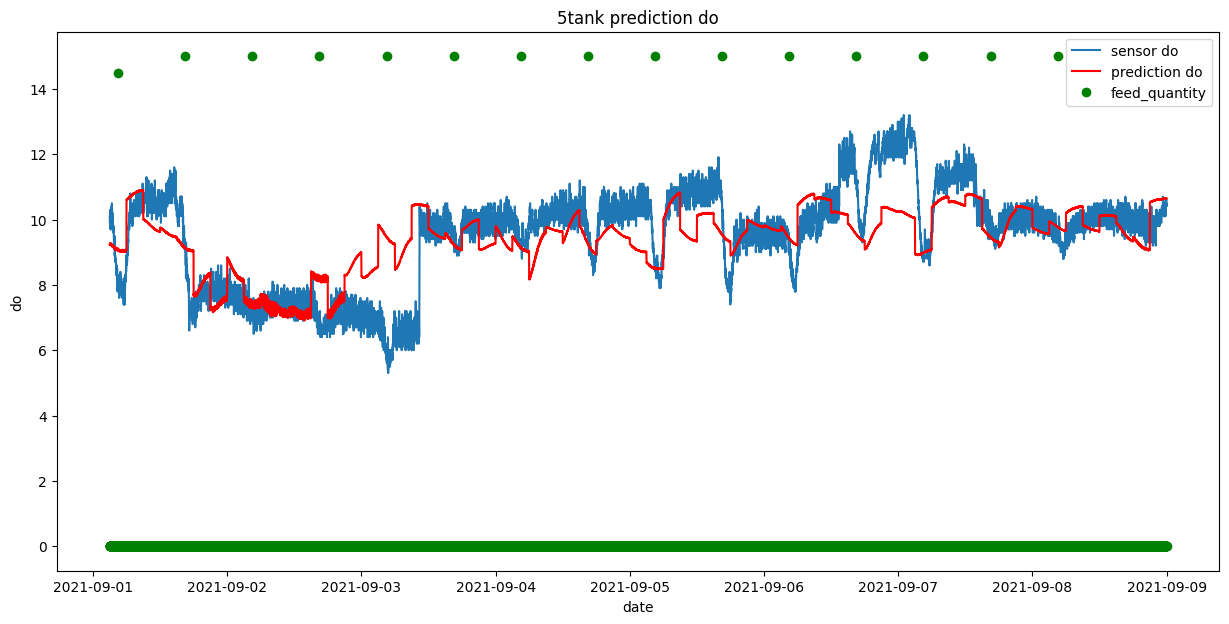

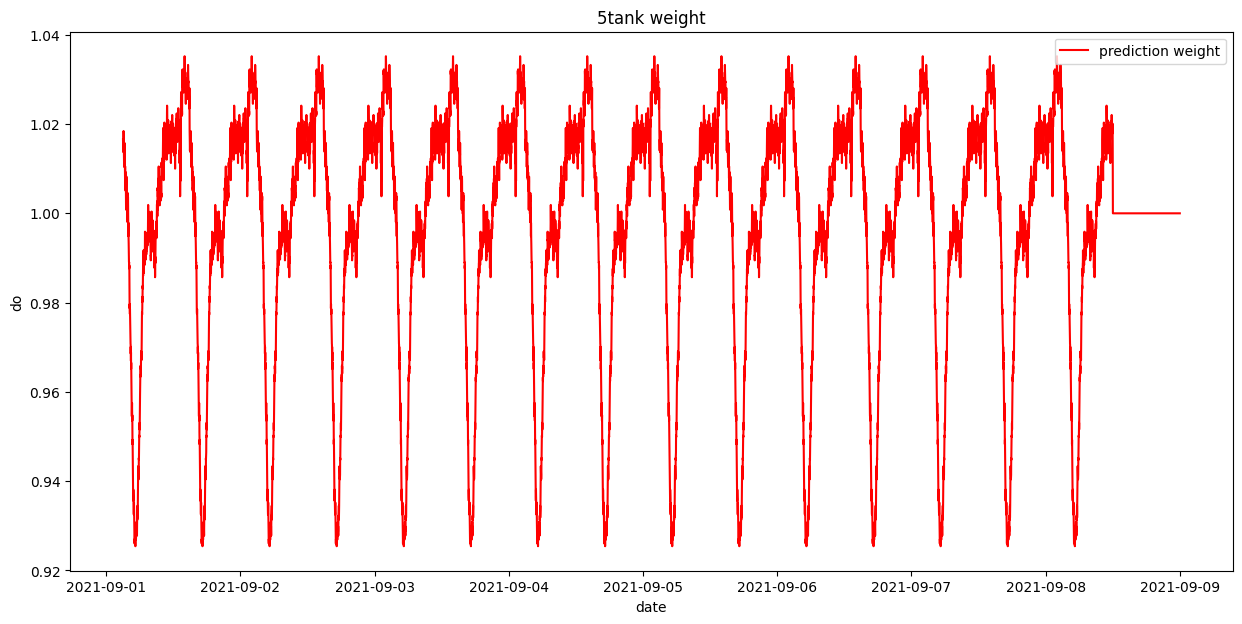

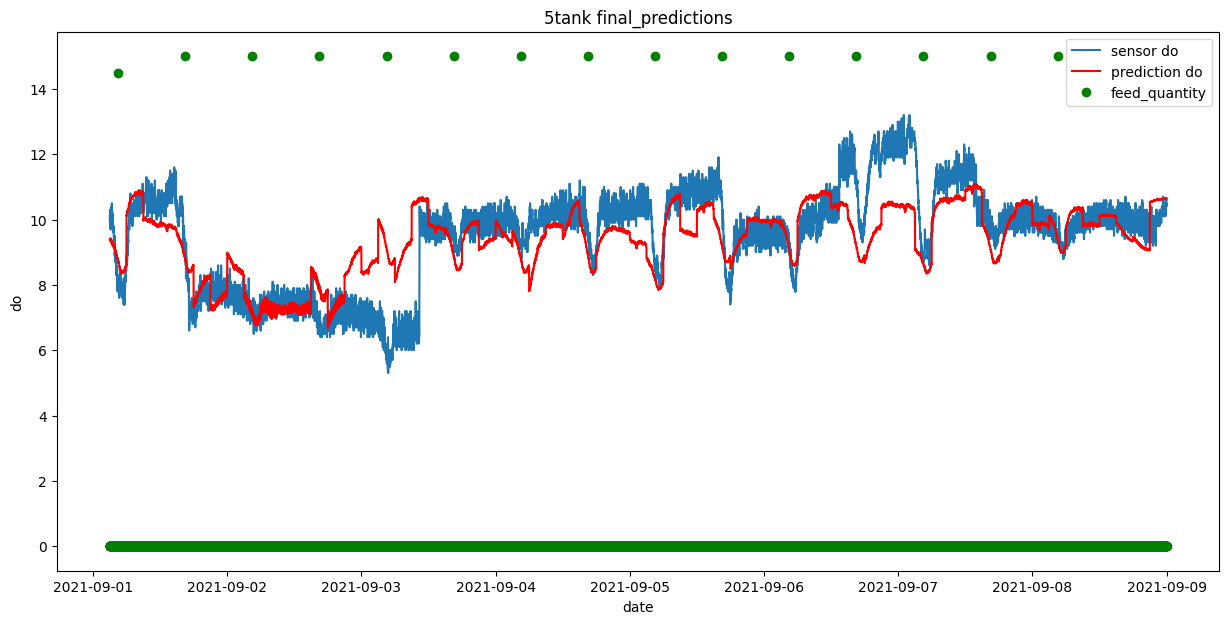

Euclidean Distance
 117.77938321251817  →  112.77443932326402
Cosine Similarity
 0.9934988684630123  →  0.9940713874701338
Correlation Coefficient
 0.31725279410480967  →  0.2844230257436966
Mean Squared Error
 1.2232789338554848  →  1.1215232949450216
Mean Absolute Error
 0.8145278174284274  →  0.7821430676741634
Correlation Coefficient
 0.6827472058951907  →  0.715576974256304


In [80]:
y_date = japonica_validation_features_y.loc['2021-09-01 03:00':'2021-09-08 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-09-01 00:00':'2021-09-08 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-09-01 03:00':'2021-09-08 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

nCar: 1260 nVar: 1
nCar: 7 nVar: 8
nCar: 7 nVar: 8
1/1 [==============================] - 0s 100ms/step


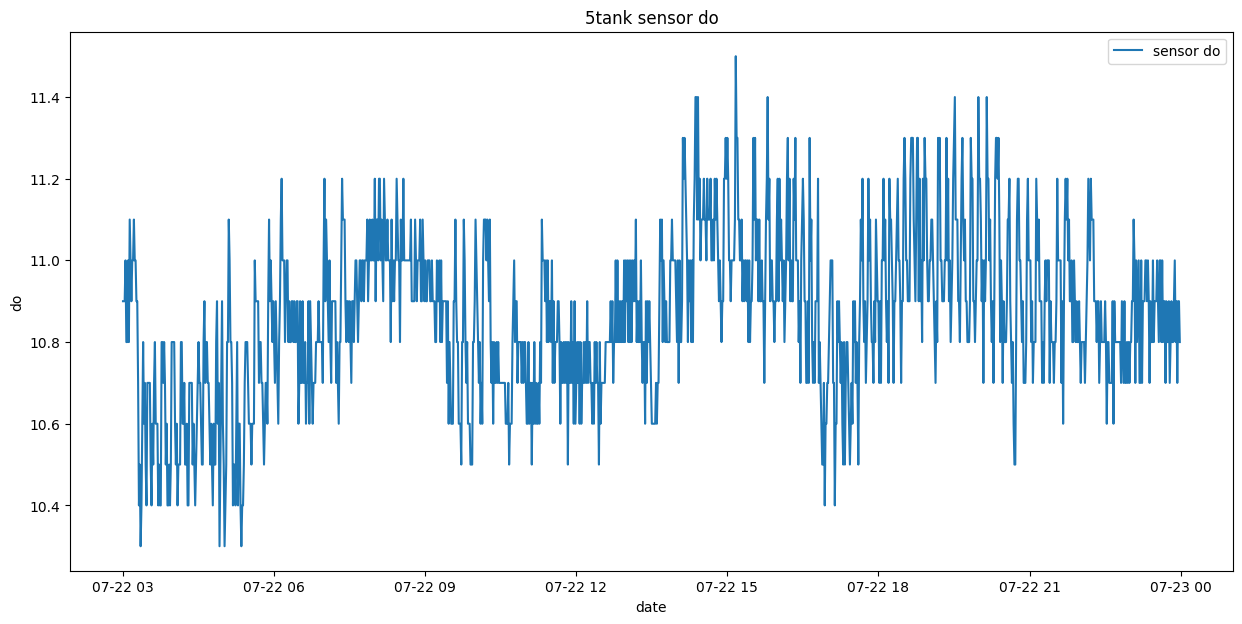

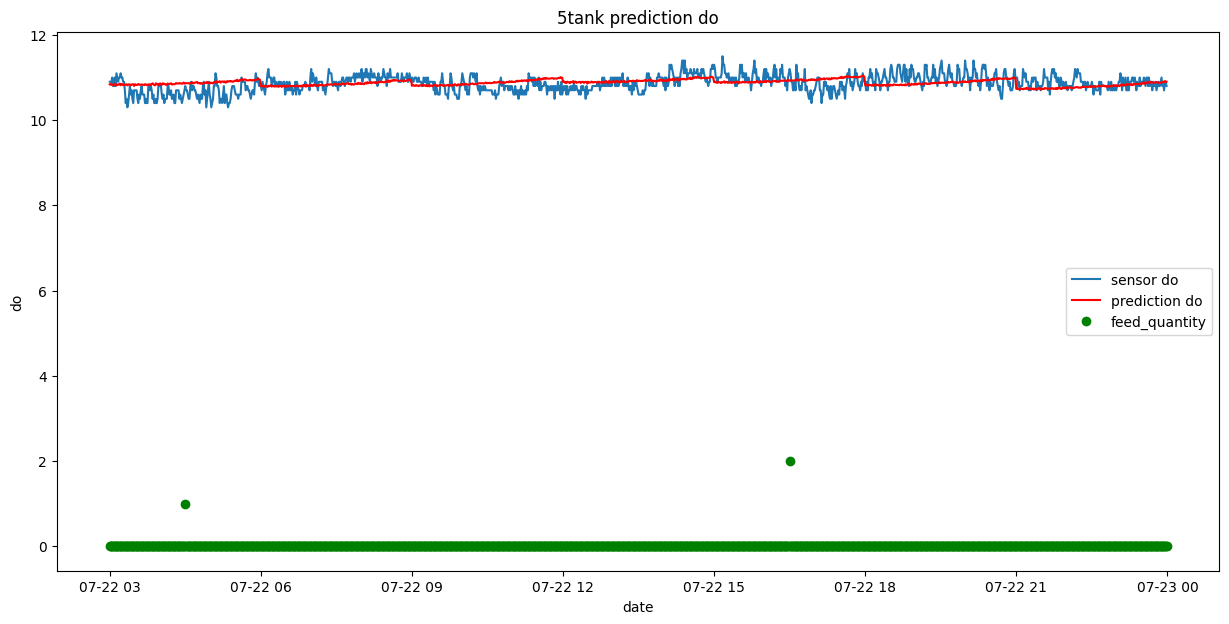

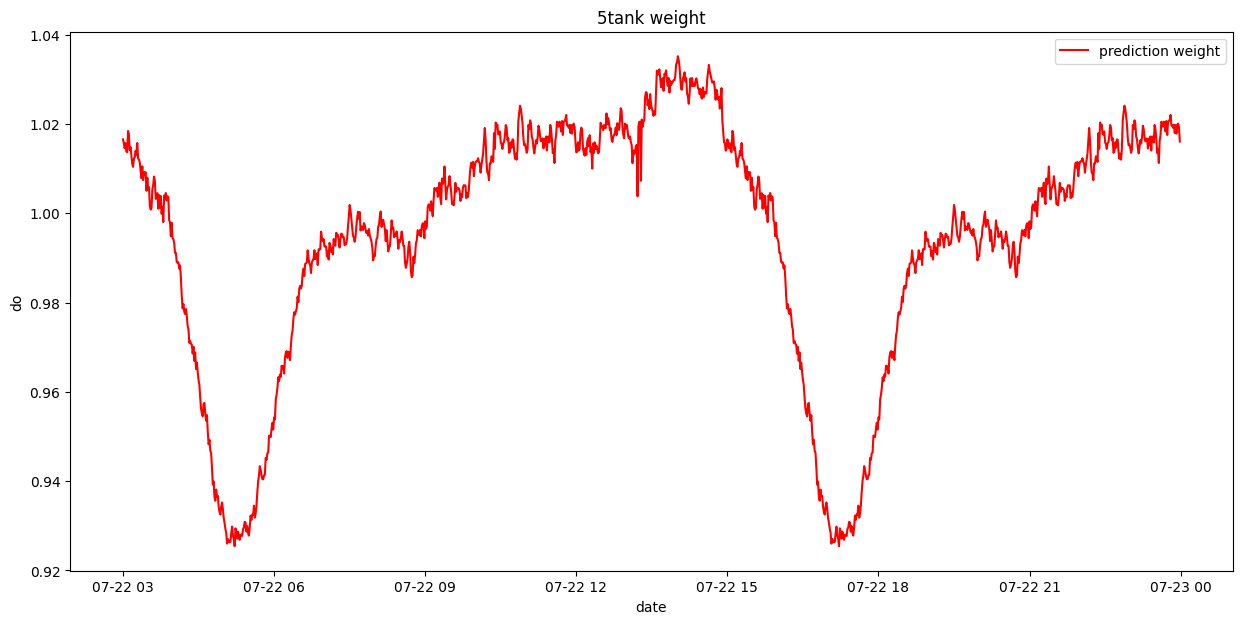

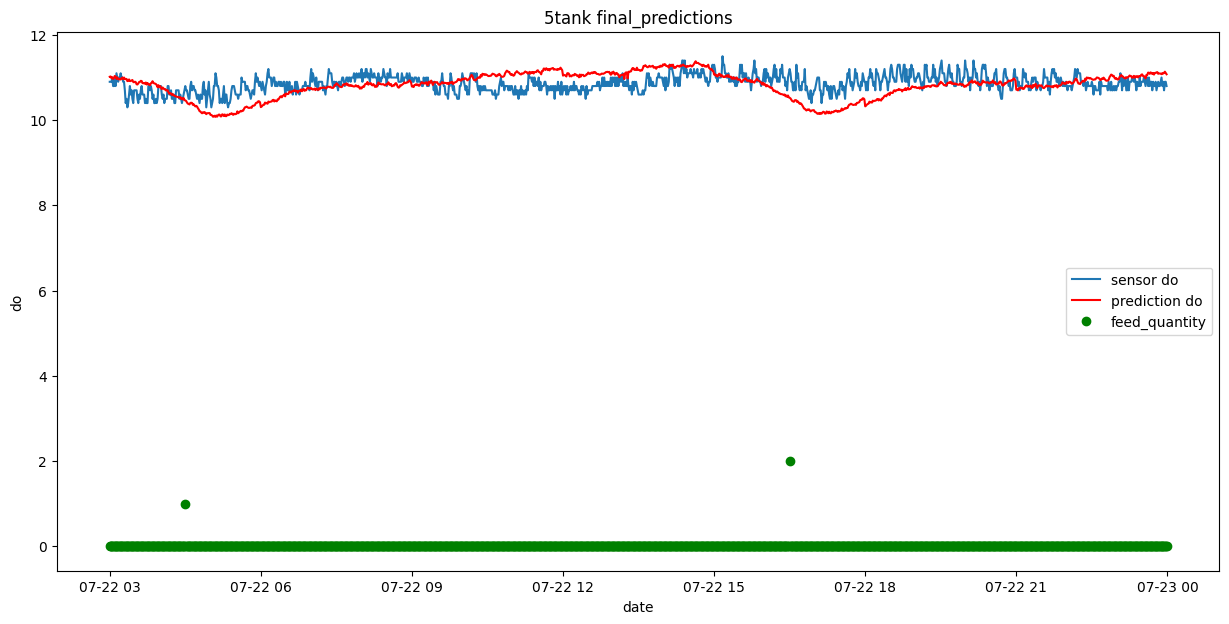

Euclidean Distance
 7.322255488130195  →  11.459202798424176
Cosine Similarity
 0.9998205093248065  →  0.9995650040249289
Correlation Coefficient
 0.9491563368955995  →  0.782863573536239
Mean Squared Error
 0.04255192494718474  →  0.1042169275995337
Mean Absolute Error
 0.1643635734679207  →  0.265697742627131
Correlation Coefficient
 0.050843663104400444  →  0.21713642646376094
nCar: 1260 nVar: 1
nCar: 7 nVar: 8
nCar: 7 nVar: 8


C:\Users\rladn\AppData\Local\Temp\ipykernel_22468\1883044233.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_features_X_a.at['2021-07-22 08:00', 'feed_quantity'] = 6
C:\Users\rladn\AppData\Local\Temp\ipykernel_22468\1883044233.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_features_X_b.at['2021-07-22 08:00', 'feed_quantity'] = 6


1/1 [==============================] - 0s 99ms/step


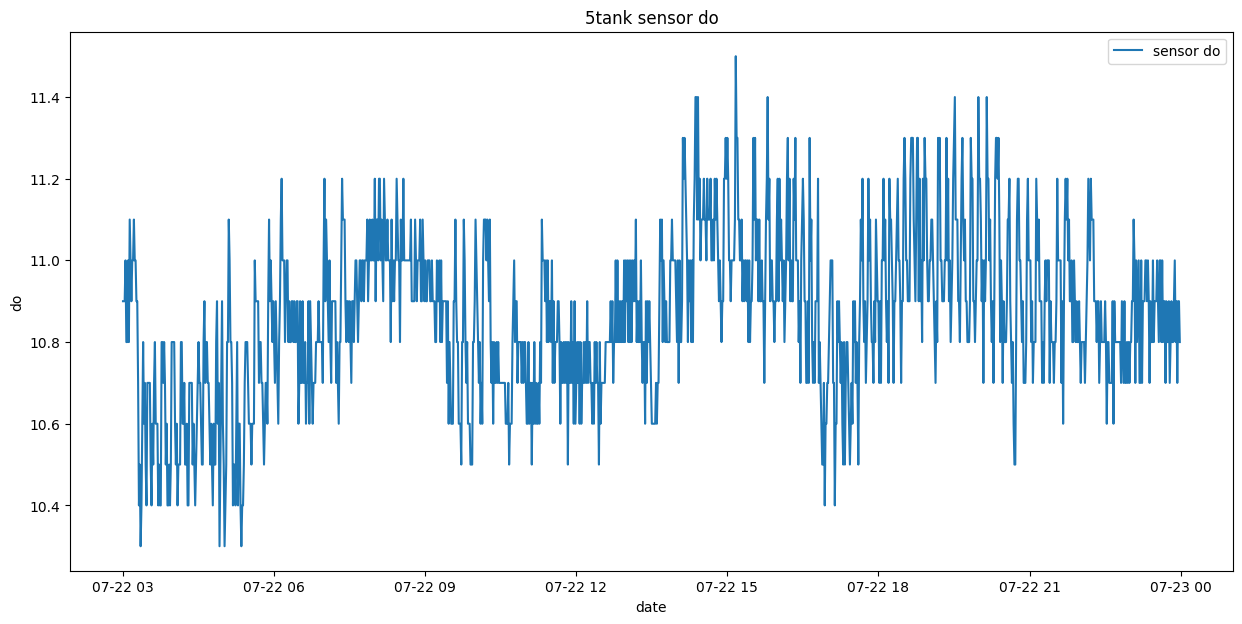

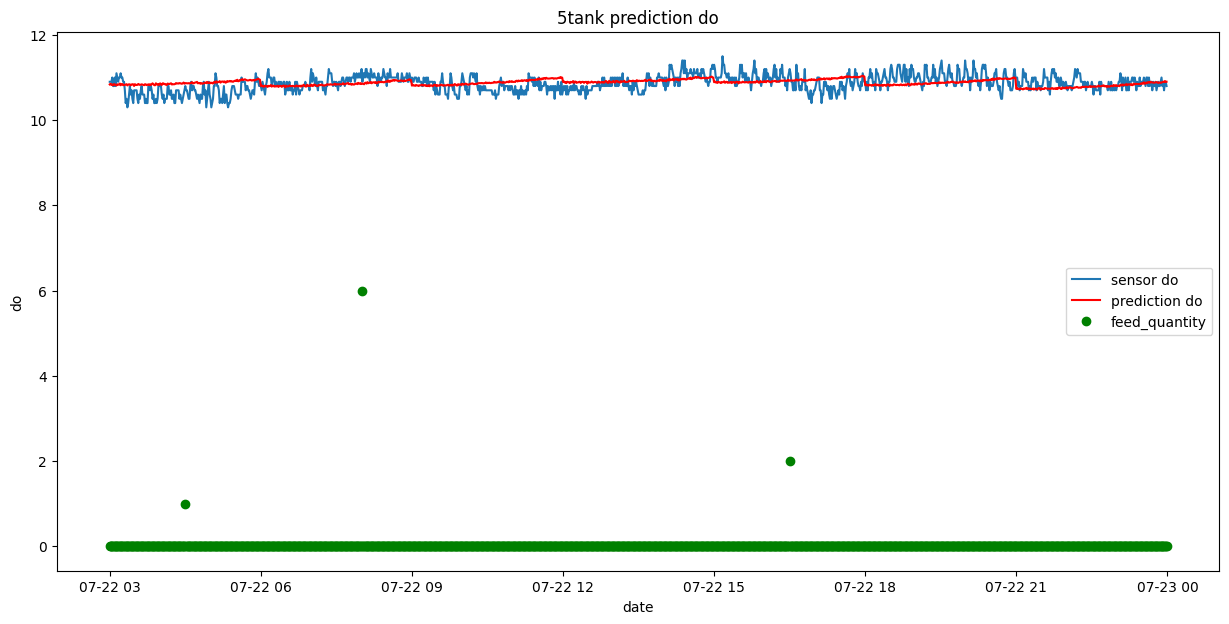

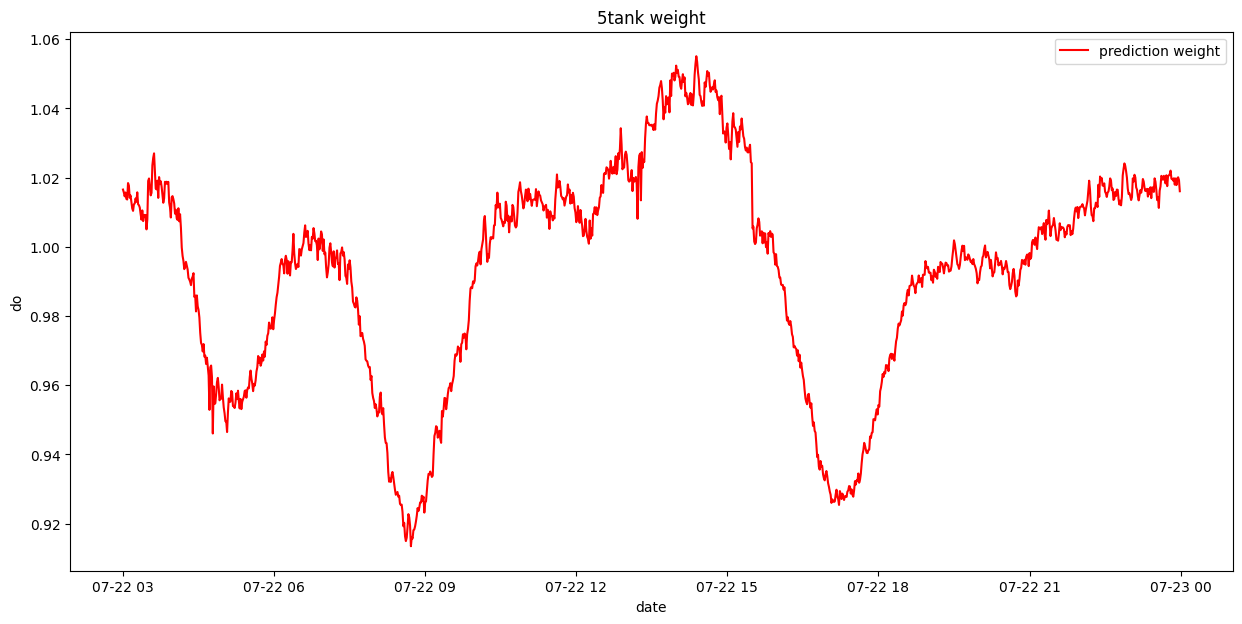

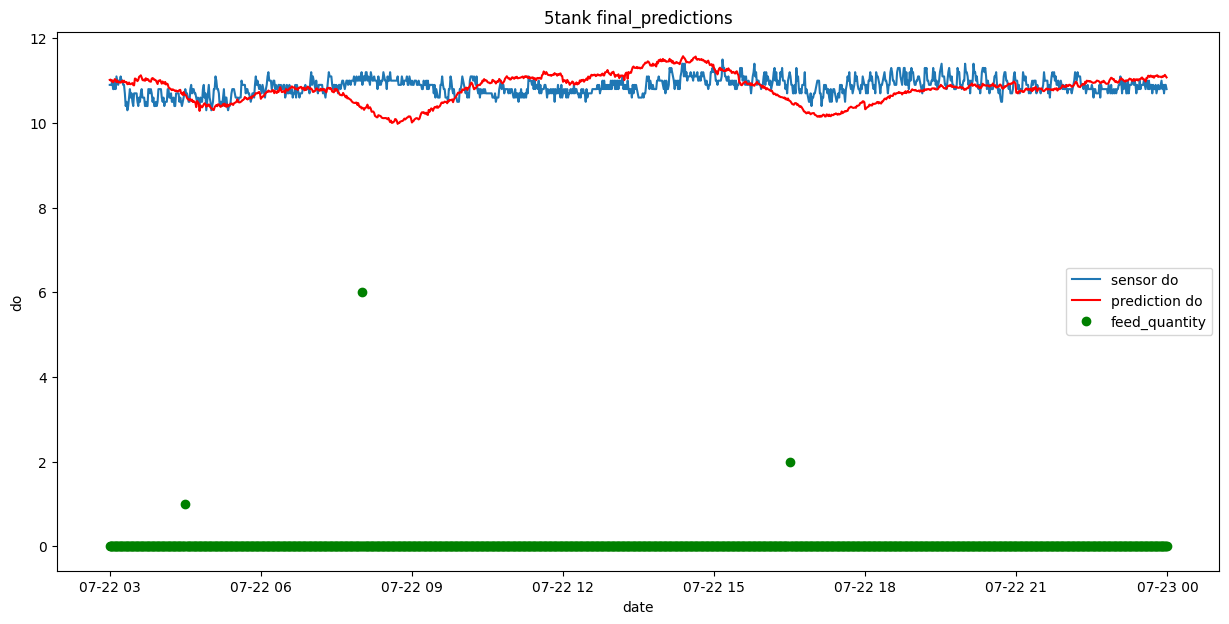

Euclidean Distance
 7.327321281216442  →  13.69357004459321
Cosine Similarity
 0.9998202976155367  →  0.999379296596977
Correlation Coefficient
 0.9510467551518439  →  0.9214325568927574
Mean Squared Error
 0.042610823141402666  →  0.14882052425887346
Mean Absolute Error
 0.16449032692682175  →  0.3120016007417752
Correlation Coefficient
 0.04895324484815608  →  0.07856744310724267


In [81]:
y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-07-22 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-07-22 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-22 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

japonica_validation_features_X_a.at['2021-07-22 08:00', 'feed_quantity'] = 6
japonica_validation_features_X_b.at['2021-07-22 08:00', 'feed_quantity'] = 6

y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-07-22 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-07-22 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-22 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

nCar: 1260 nVar: 1
nCar: 7 nVar: 8
nCar: 7 nVar: 8
1/1 [==============================] - 1s 1s/step


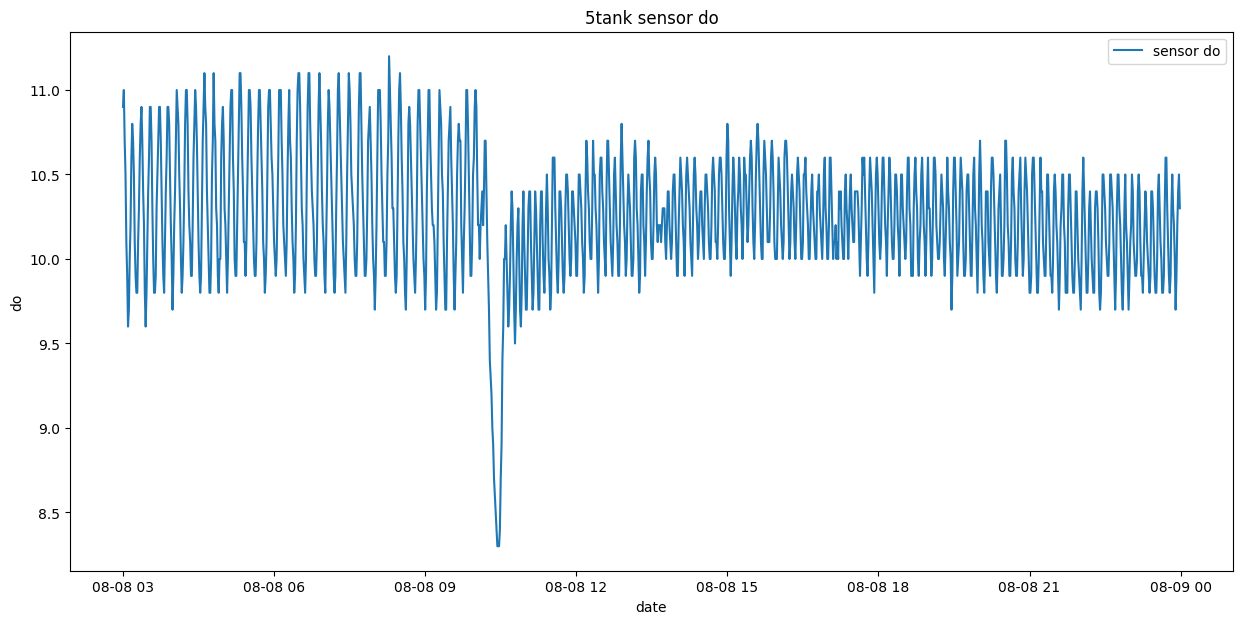

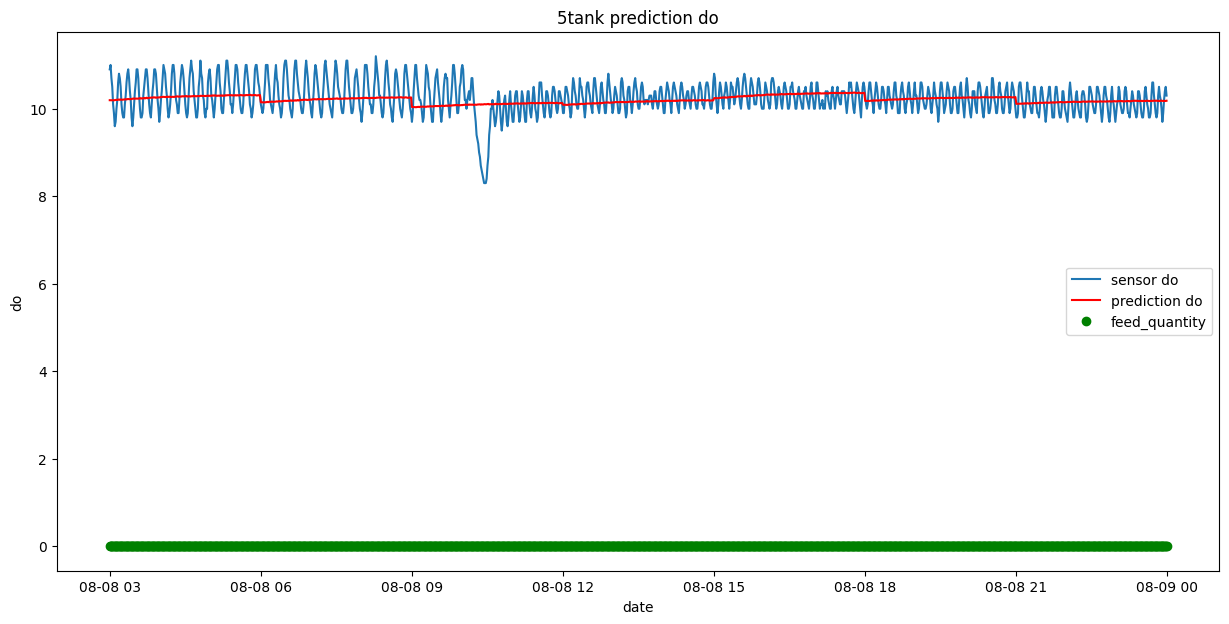

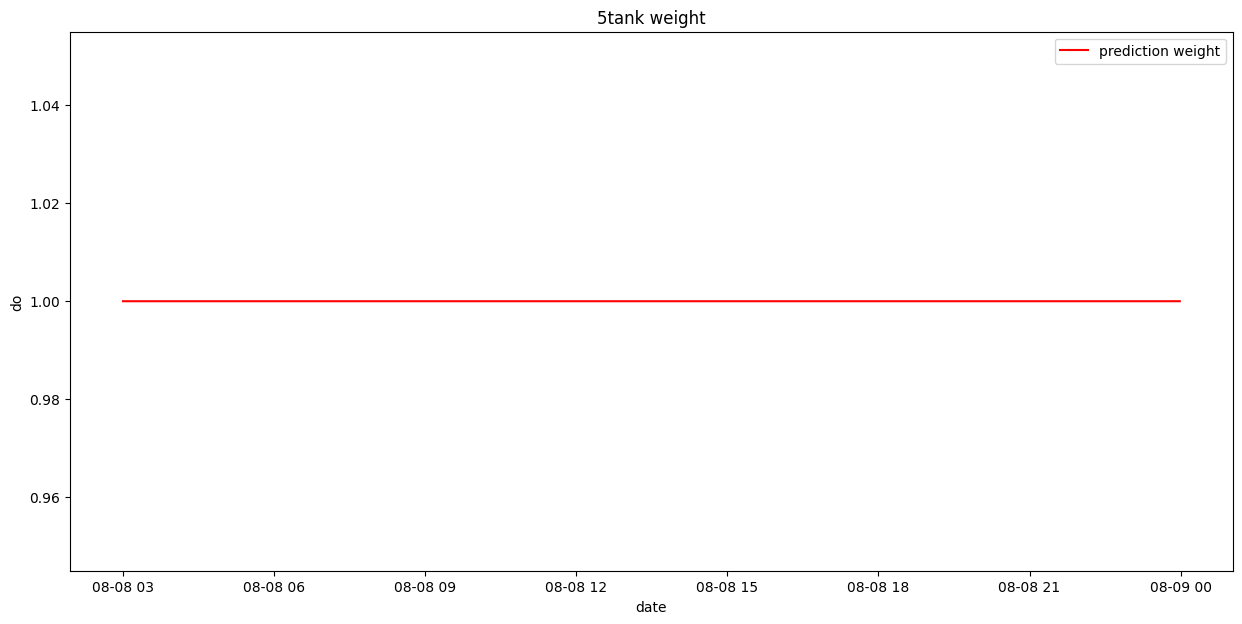

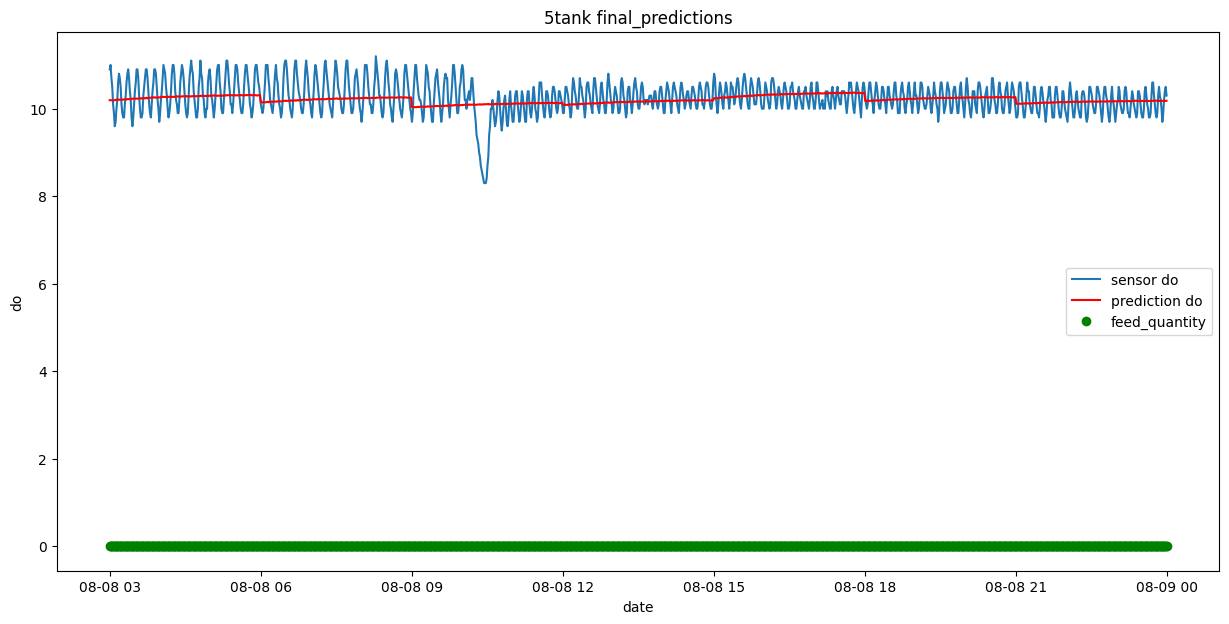

Euclidean Distance
 13.105171563824566  →  13.105171563824566
Cosine Similarity
 0.9993648411152836  →  0.9993648411152836
Correlation Coefficient
 0.8173758985092505  →  0.8173758985092505
Mean Squared Error
 0.13630596961688576  →  0.13630596961688576
Mean Absolute Error
 0.28800935487898577  →  0.28800935487898577
Correlation Coefficient
 0.18262410149074956  →  0.18262410149074956
nCar: 1260 nVar: 1
nCar: 7 nVar: 8
nCar: 7 nVar: 8


C:\Users\rladn\AppData\Local\Temp\ipykernel_22468\1112980633.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_features_X_a.at['2021-08-08 08:00', 'feed_quantity'] = 6
C:\Users\rladn\AppData\Local\Temp\ipykernel_22468\1112980633.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_features_X_b.at['2021-08-08 08:00', 'feed_quantity'] = 6


1/1 [==============================] - 1s 1s/step


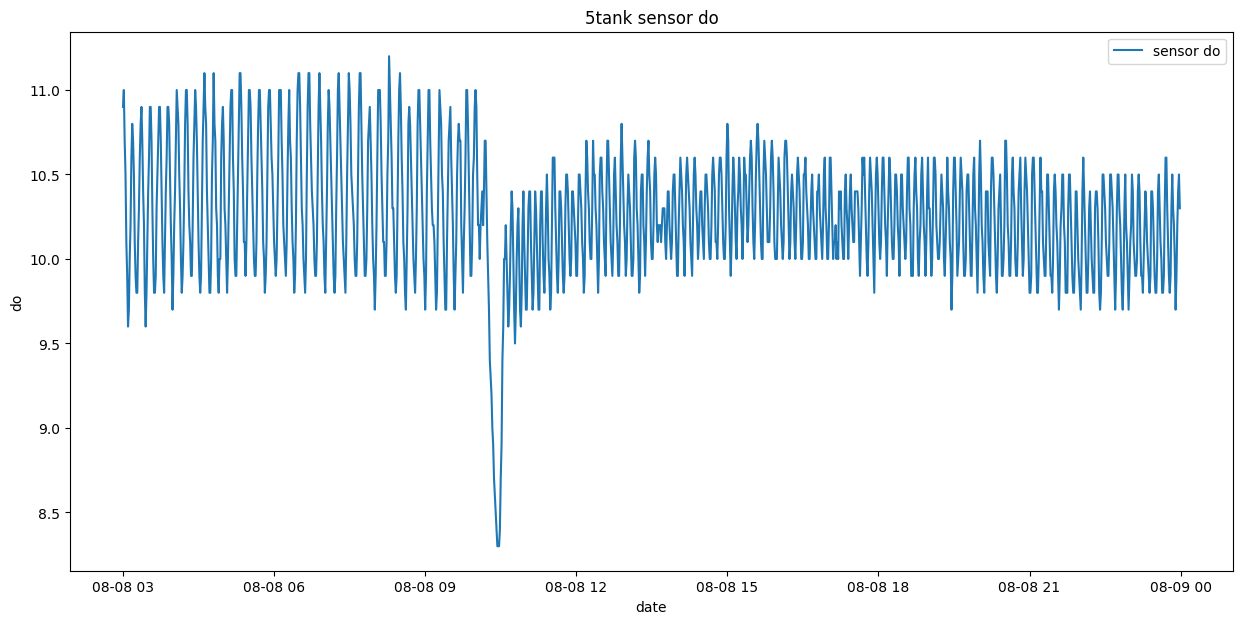

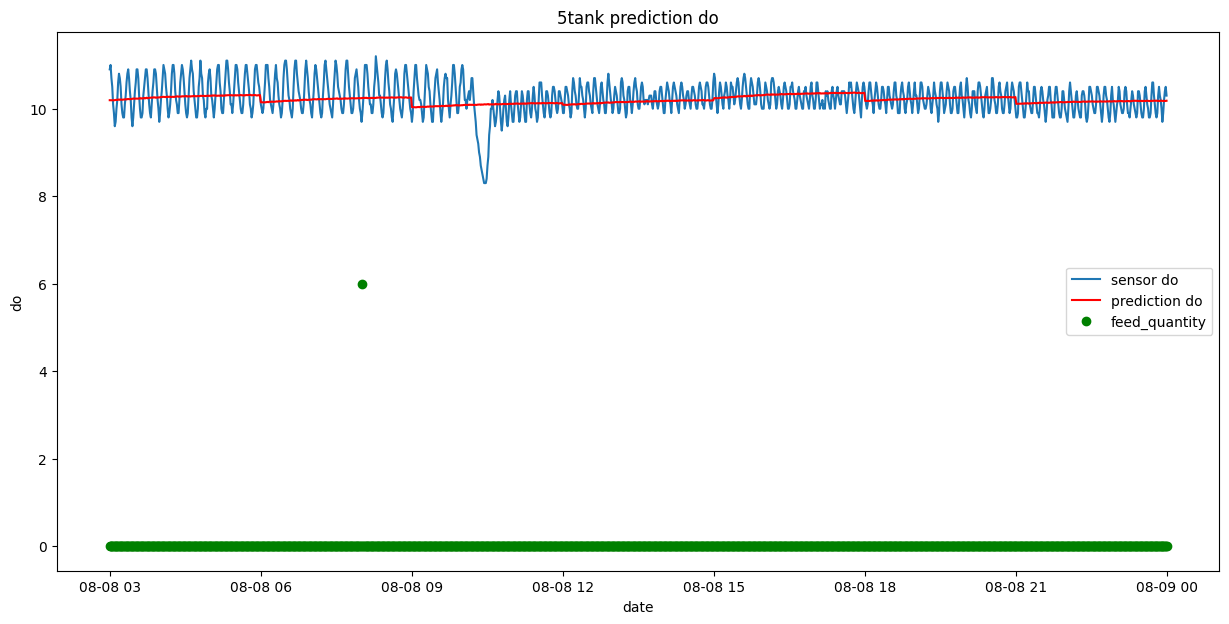

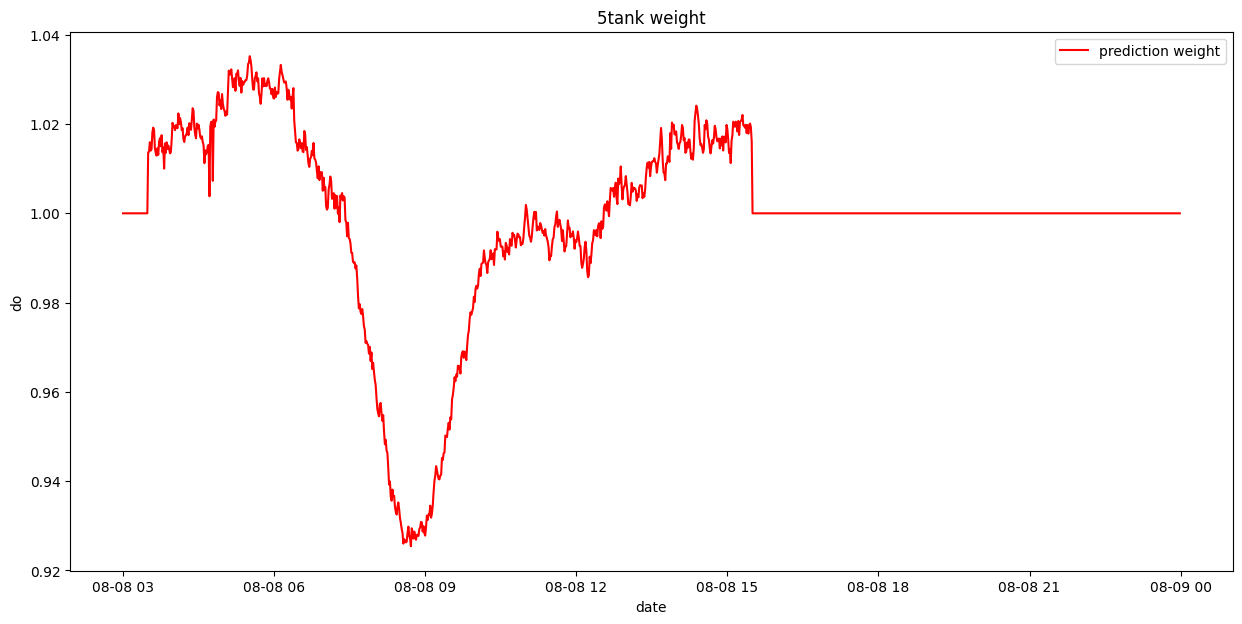

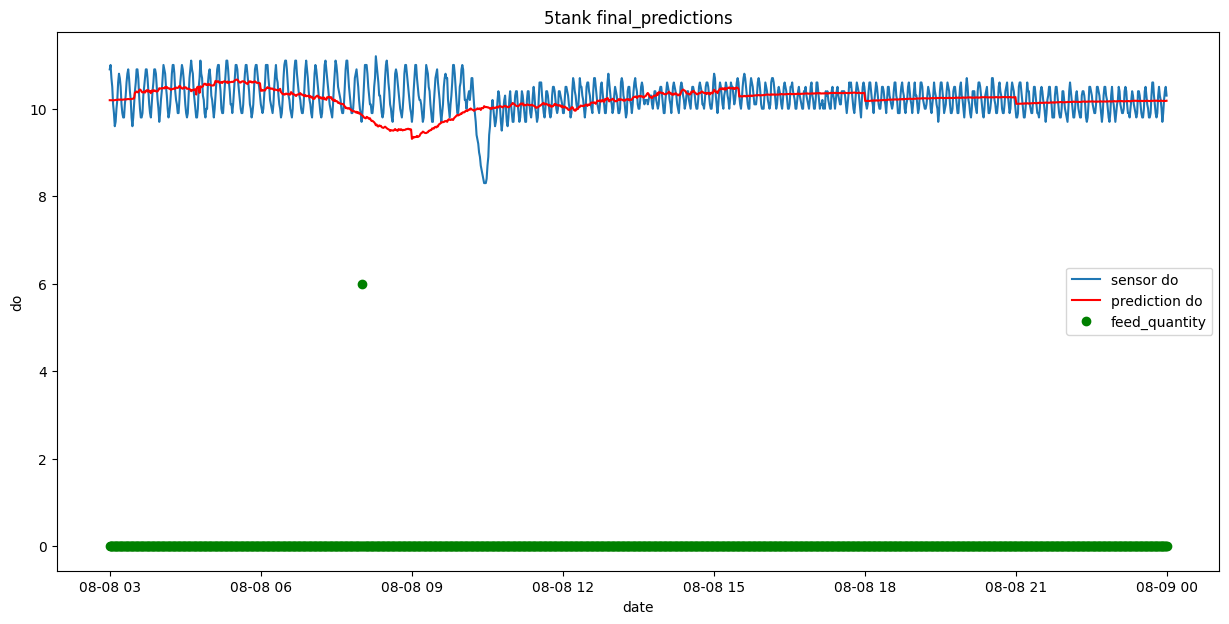

Euclidean Distance
 13.104128836885991  →  15.391056798907417
Cosine Similarity
 0.9993651614512552  →  0.9991221872595021
Correlation Coefficient
 0.8159825460399844  →  0.9211540953372778
Mean Squared Error
 0.1362842798204023  →  0.18800367411682078
Mean Absolute Error
 0.28803089959280836  →  0.32495658543963124
Correlation Coefficient
 0.18401745396001562  →  0.0788459046627222


In [82]:
y_date = japonica_validation_features_y.loc['2021-08-08 03:00':'2021-08-08 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-08-08 00:00':'2021-08-08 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-08-08 03:00':'2021-08-08 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

japonica_validation_features_X_a.at['2021-08-08 08:00', 'feed_quantity'] = 6
japonica_validation_features_X_b.at['2021-08-08 08:00', 'feed_quantity'] = 6

y_date = japonica_validation_features_y.loc['2021-08-08 03:00':'2021-08-08 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-08-08 00:00':'2021-08-08 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-08-08 03:00':'2021-08-08 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

nCar: 1260 nVar: 1
nCar: 7 nVar: 8
nCar: 7 nVar: 8
1/1 [==============================] - 0s 94ms/step


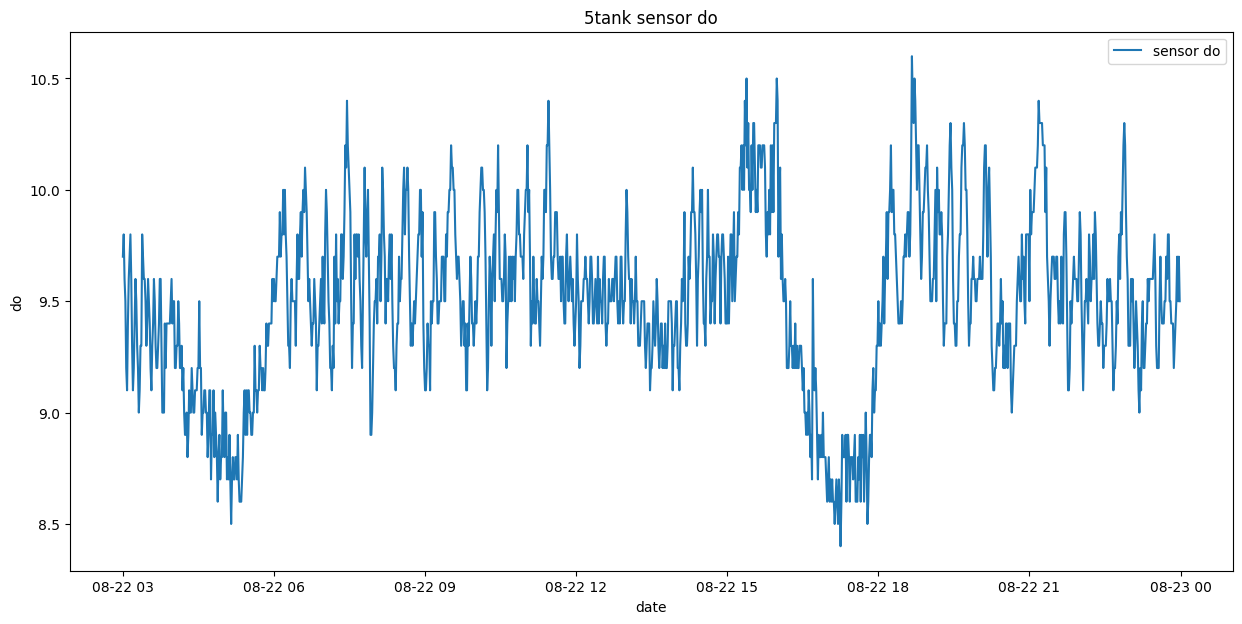

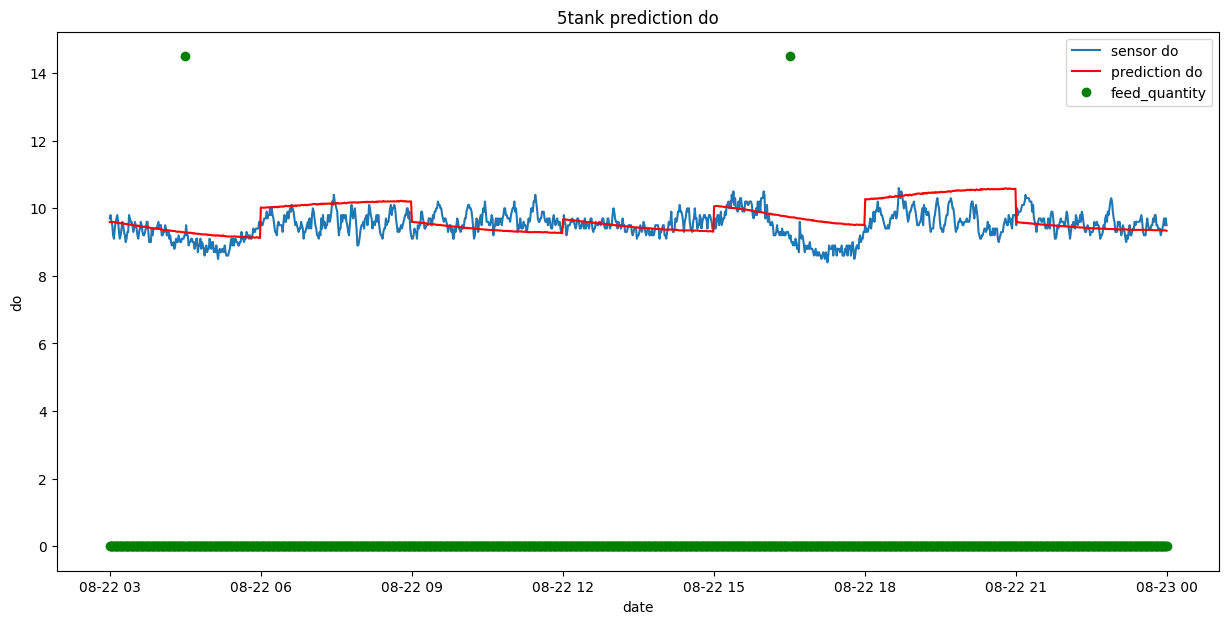

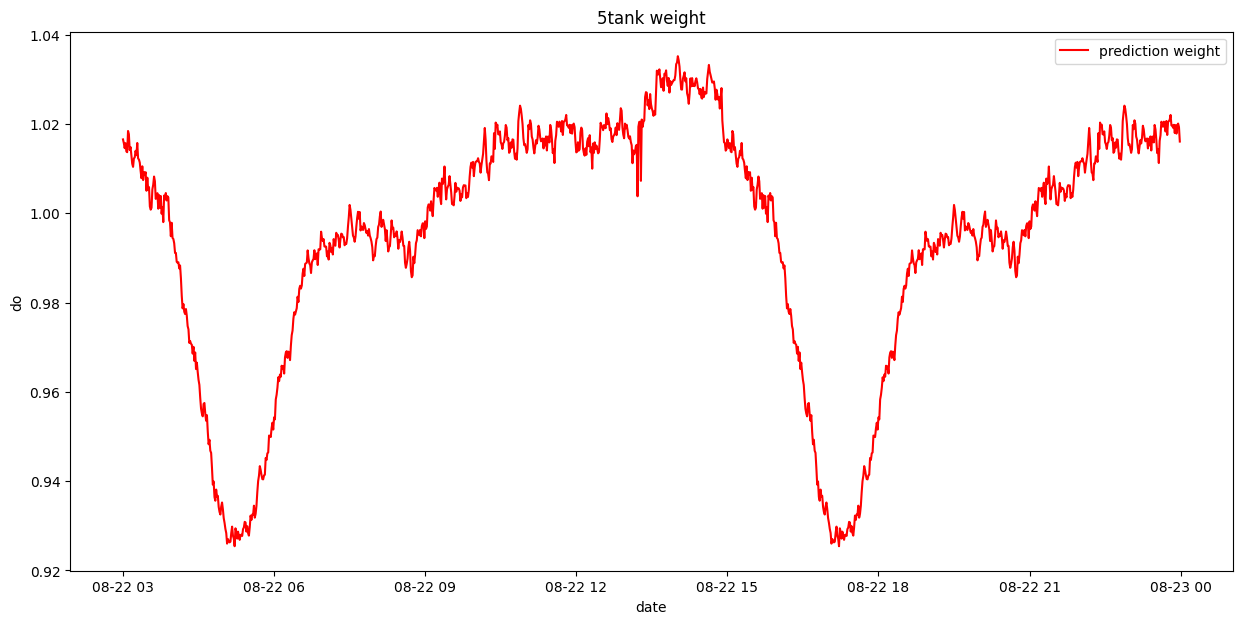

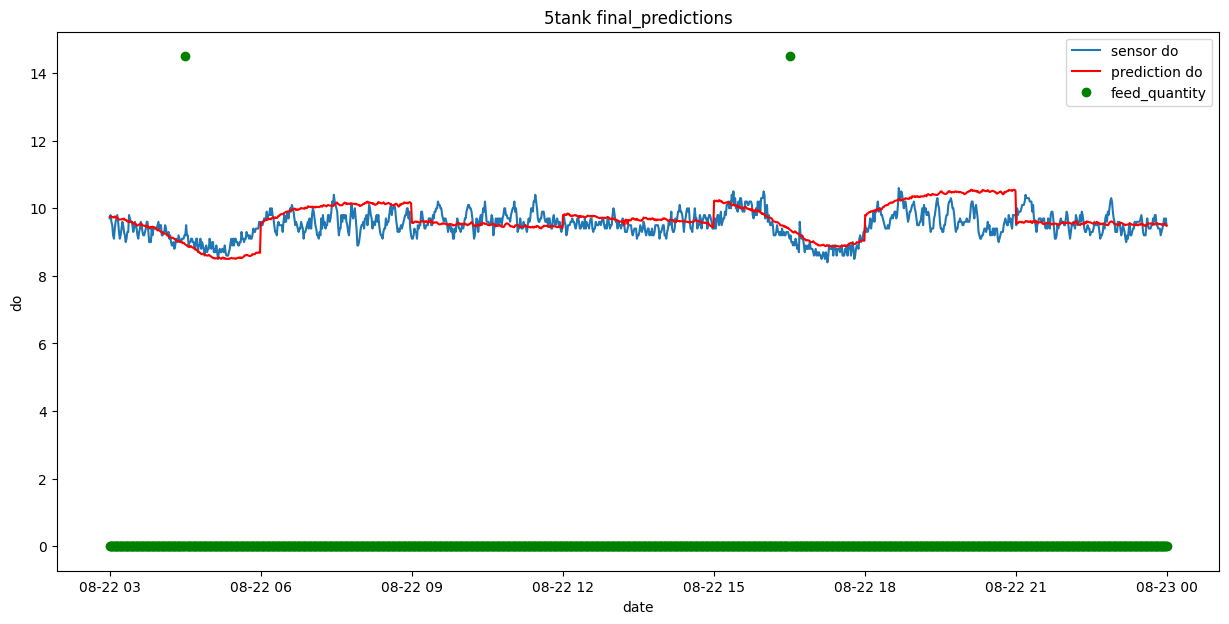

Euclidean Distance
 18.159144971846015  →  15.276612427308436
Cosine Similarity
 0.9988153513642923  →  0.9991260116690494
Correlation Coefficient
 0.6832118425359787  →  0.4205217226286573
Mean Squared Error
 0.2617099572289844  →  0.18521816448745598
Mean Absolute Error
 0.39887861009628045  →  0.3279615543676567
Correlation Coefficient
 0.3167881574640214  →  0.5794782773713428
nCar: 1260 nVar: 1
nCar: 7 nVar: 8
nCar: 7 nVar: 8


C:\Users\rladn\AppData\Local\Temp\ipykernel_22468\3030402602.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_features_X_a.at['2021-08-22 08:00', 'feed_quantity'] = 6
C:\Users\rladn\AppData\Local\Temp\ipykernel_22468\3030402602.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_features_X_b.at['2021-08-22 08:00', 'feed_quantity'] = 6


1/1 [==============================] - 0s 100ms/step


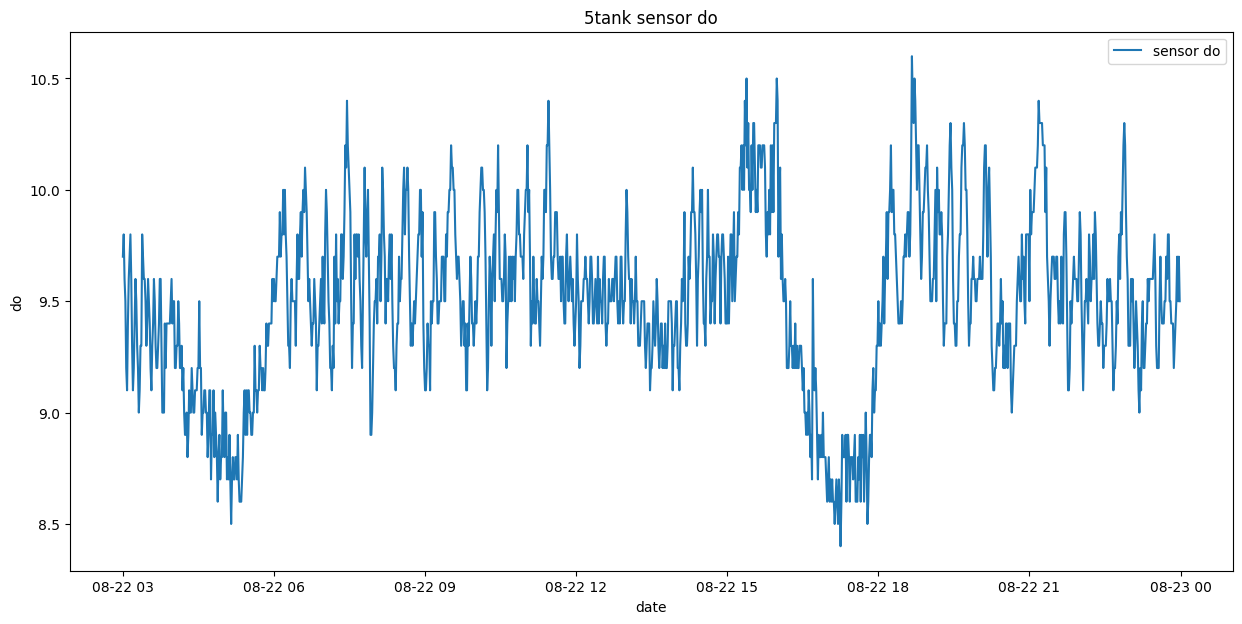

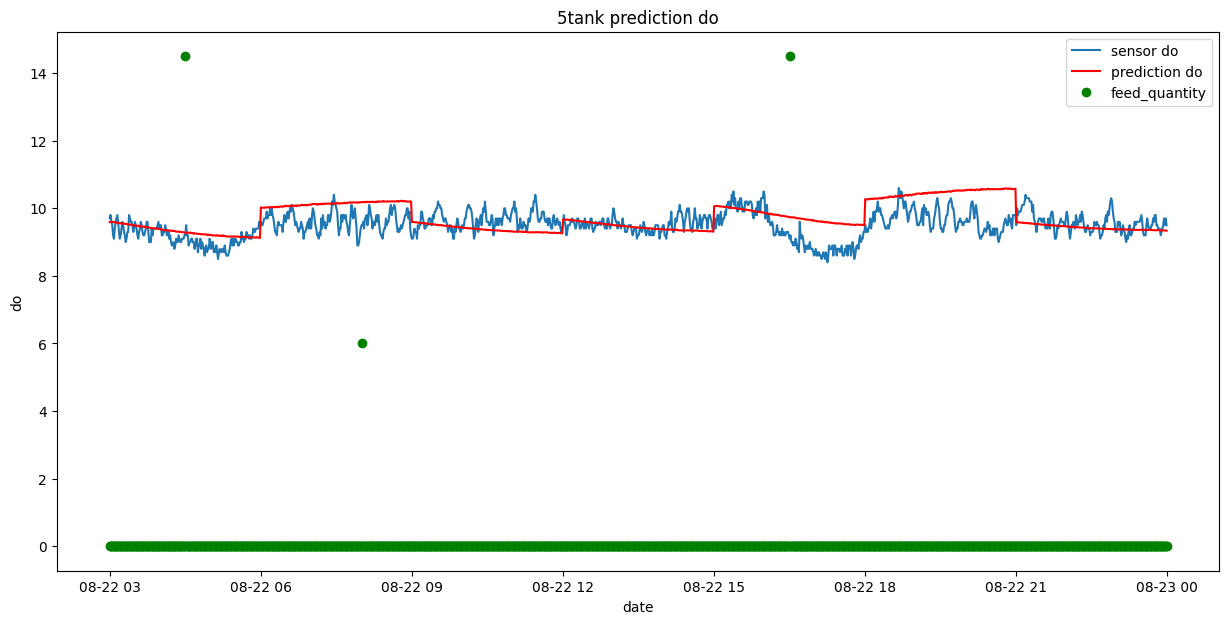

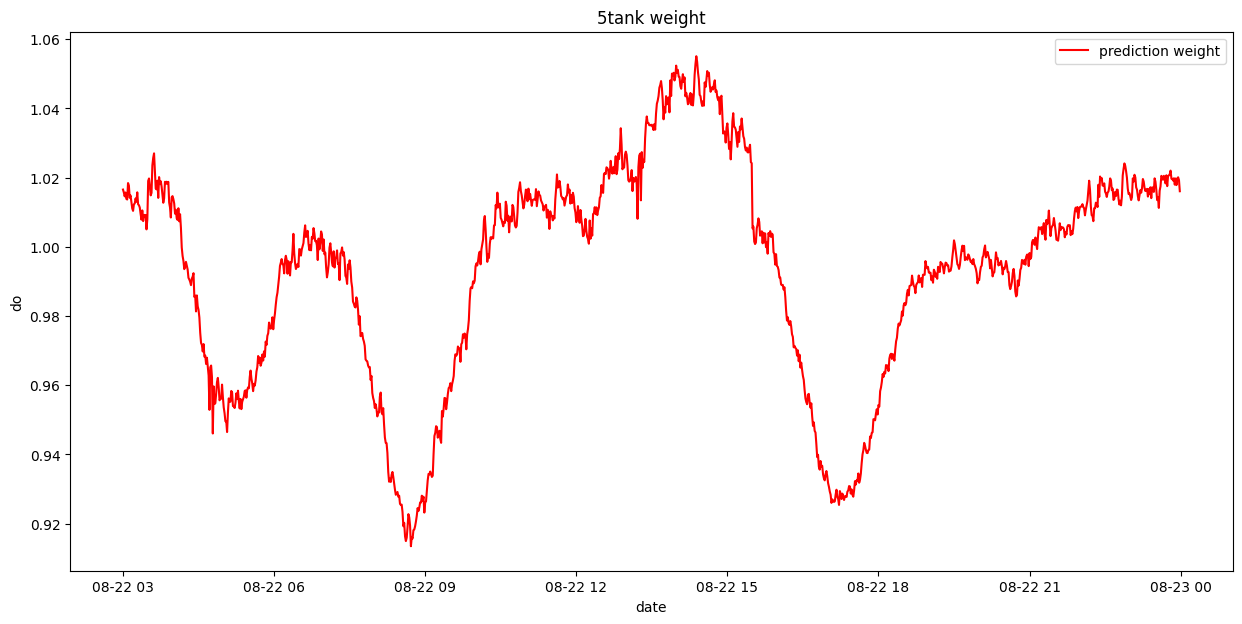

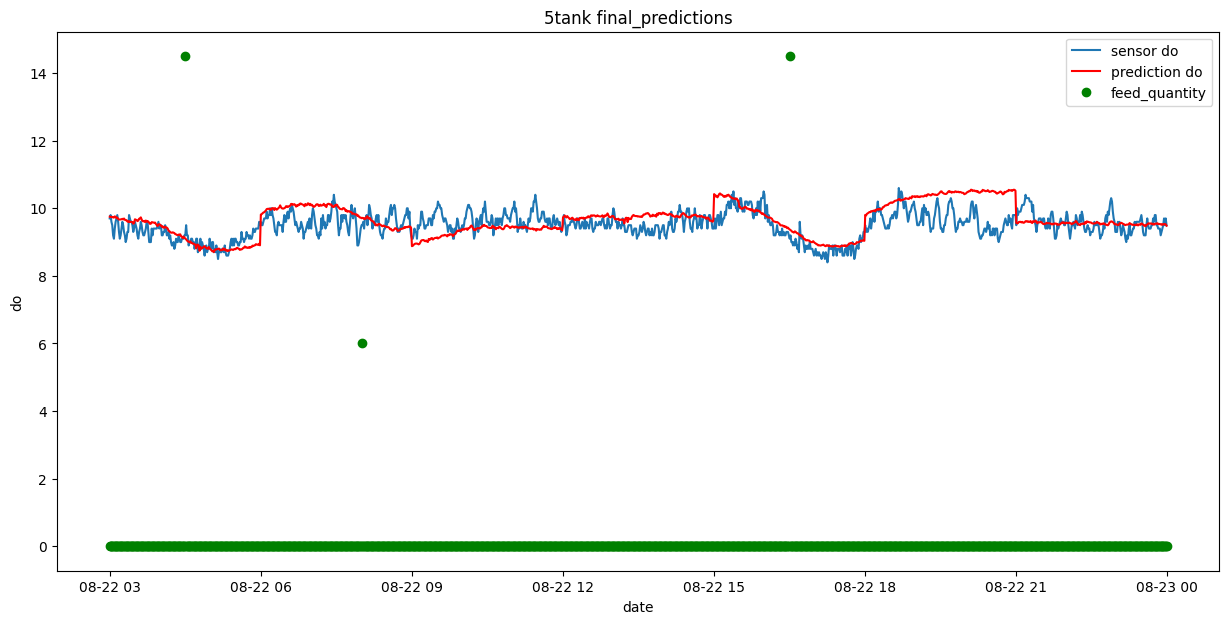

Euclidean Distance
 18.170332634398036  →  15.376871925311269
Cosine Similarity
 0.9988122858330728  →  0.9990867735738572
Correlation Coefficient
 0.6841077286788817  →  0.469258593926706
Mean Squared Error
 0.26203253019418266  →  0.18765729381541735
Mean Absolute Error
 0.39925384990752677  →  0.33166116460912176
Correlation Coefficient
 0.31589227132111836  →  0.5307414060732942


In [83]:
y_date = japonica_validation_features_y.loc['2021-08-22 03:00':'2021-08-22 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-08-22 00:00':'2021-08-22 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-08-22 03:00':'2021-08-22 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

japonica_validation_features_X_a.at['2021-08-22 08:00', 'feed_quantity'] = 6
japonica_validation_features_X_b.at['2021-08-22 08:00', 'feed_quantity'] = 6

y_date = japonica_validation_features_y.loc['2021-08-22 03:00':'2021-08-22 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-08-22 00:00':'2021-08-22 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-08-22 03:00':'2021-08-22 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

nCar: 1260 nVar: 1
nCar: 7 nVar: 8
nCar: 7 nVar: 8
1/1 [==============================] - 0s 108ms/step


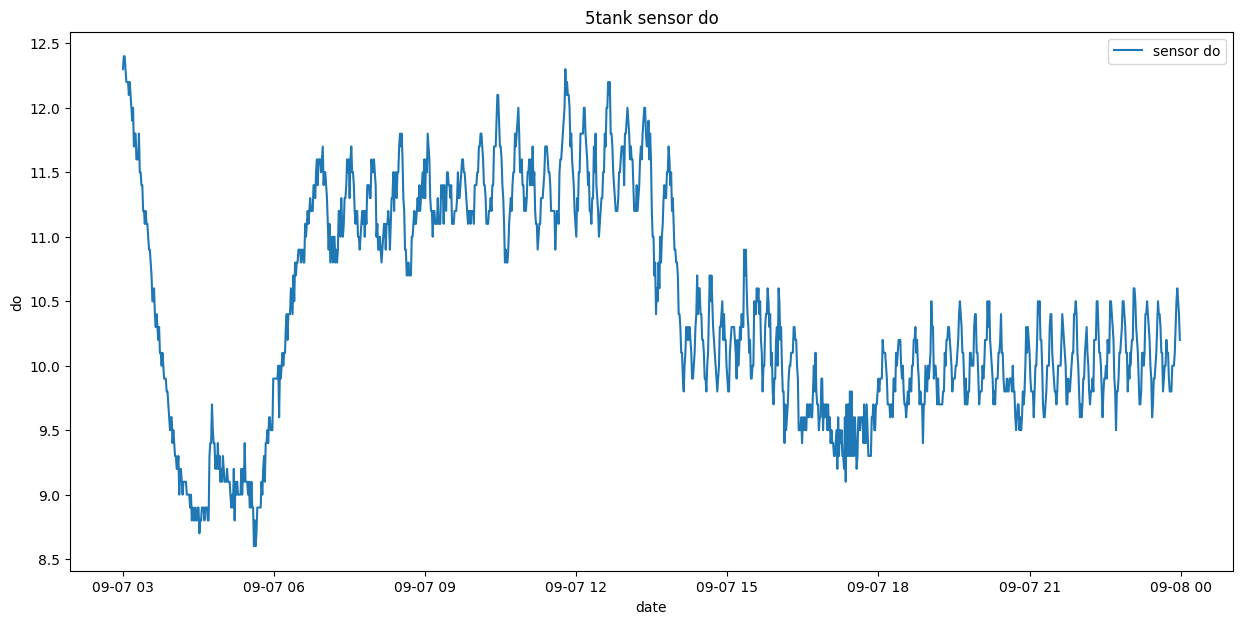

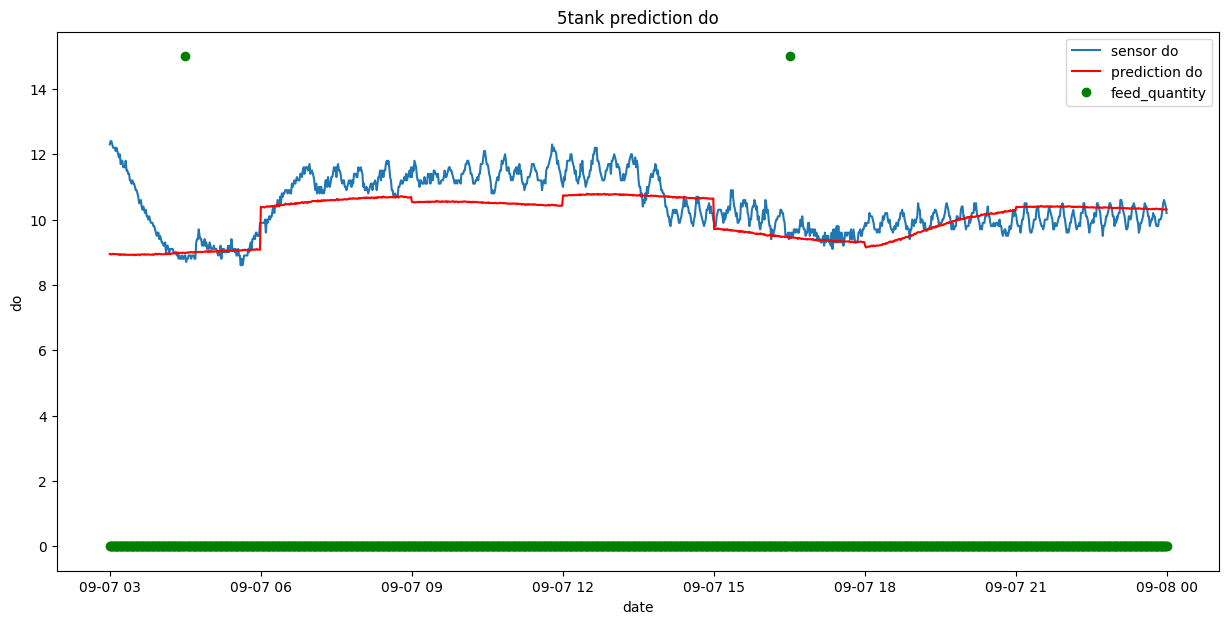

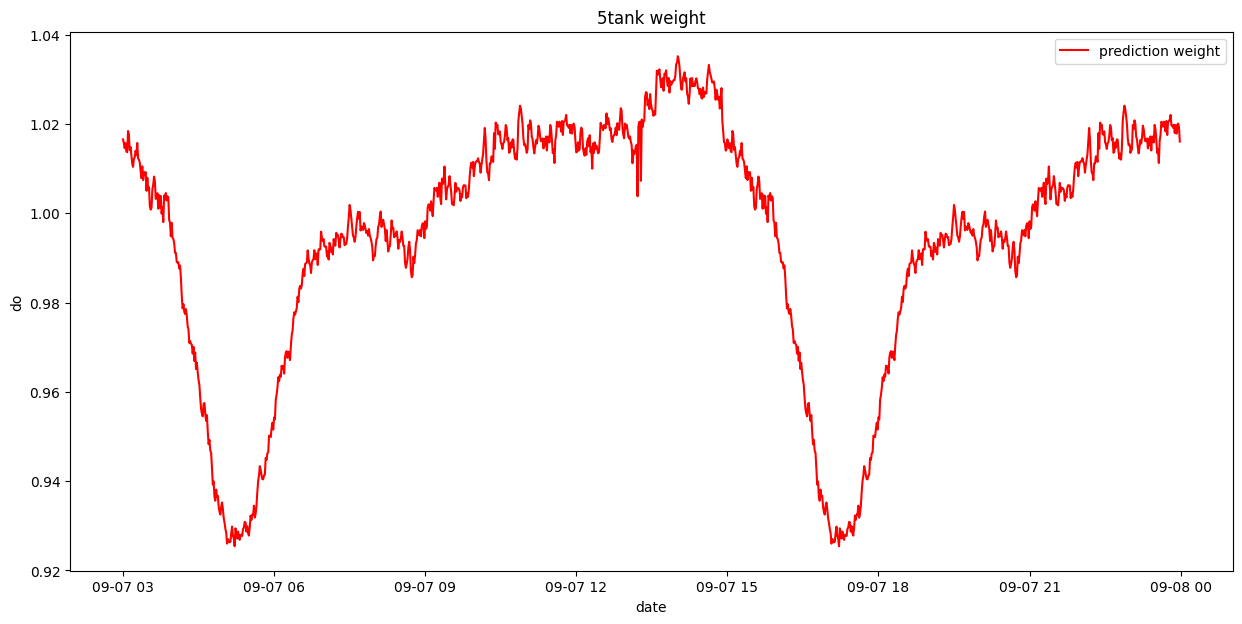

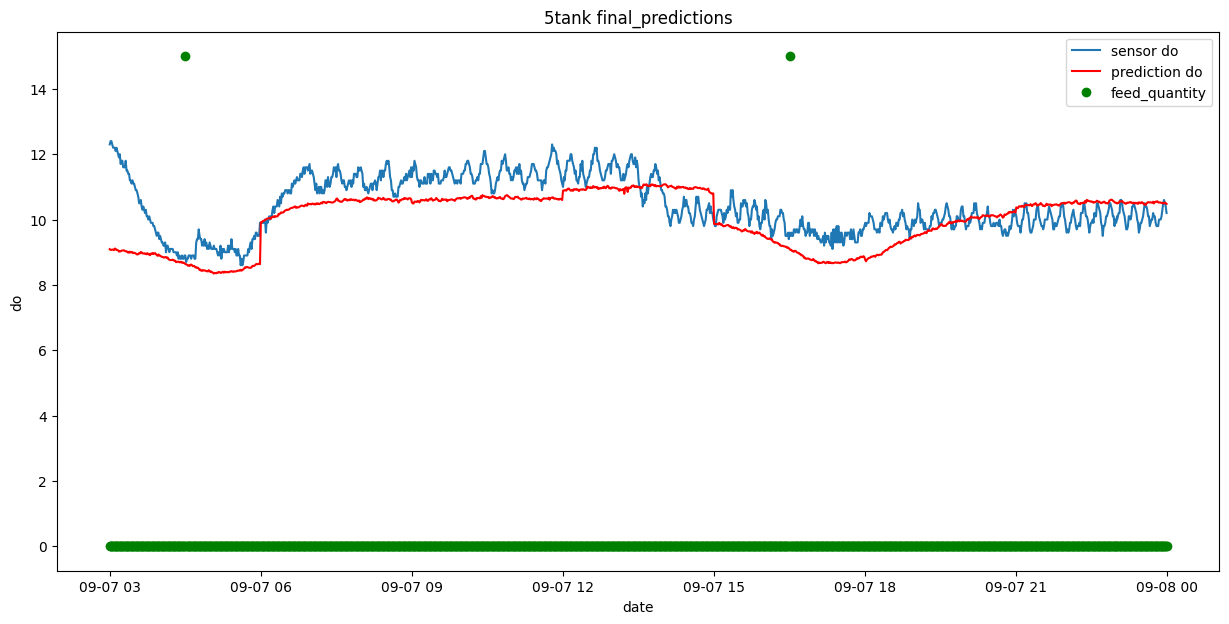

Euclidean Distance
 27.06392917242827  →  28.204190376223654
Cosine Similarity
 0.9979780733436799  →  0.9978433984341335
Correlation Coefficient
 0.3658018726581097  →  0.3238091904803596
Mean Squared Error
 0.5813144938493758  →  0.6313304403002116
Mean Absolute Error
 0.5676256627885122  →  0.6464911698740599
Correlation Coefficient
 0.6341981273418905  →  0.6761908095196404
nCar: 1260 nVar: 1
nCar: 7 nVar: 8
nCar: 7 nVar: 8


C:\Users\rladn\AppData\Local\Temp\ipykernel_22468\23771669.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_features_X_a.at['2021-09-07 08:00', 'feed_quantity'] = 6
C:\Users\rladn\AppData\Local\Temp\ipykernel_22468\23771669.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_features_X_b.at['2021-09-07 08:00', 'feed_quantity'] = 6


1/1 [==============================] - 0s 98ms/step


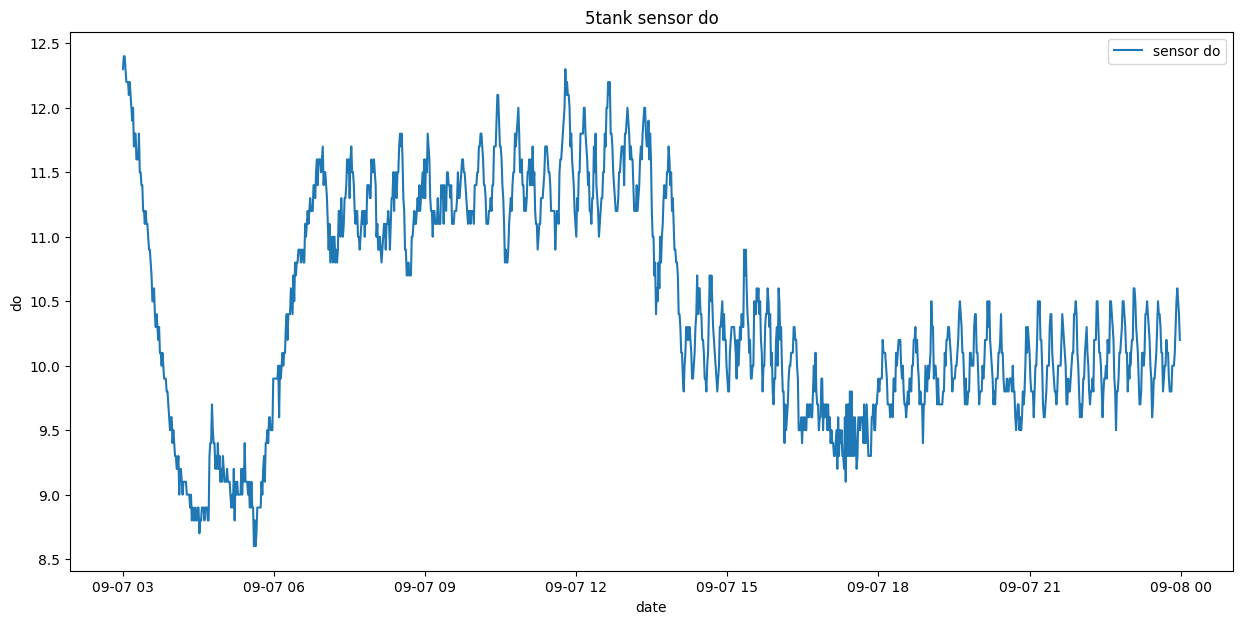

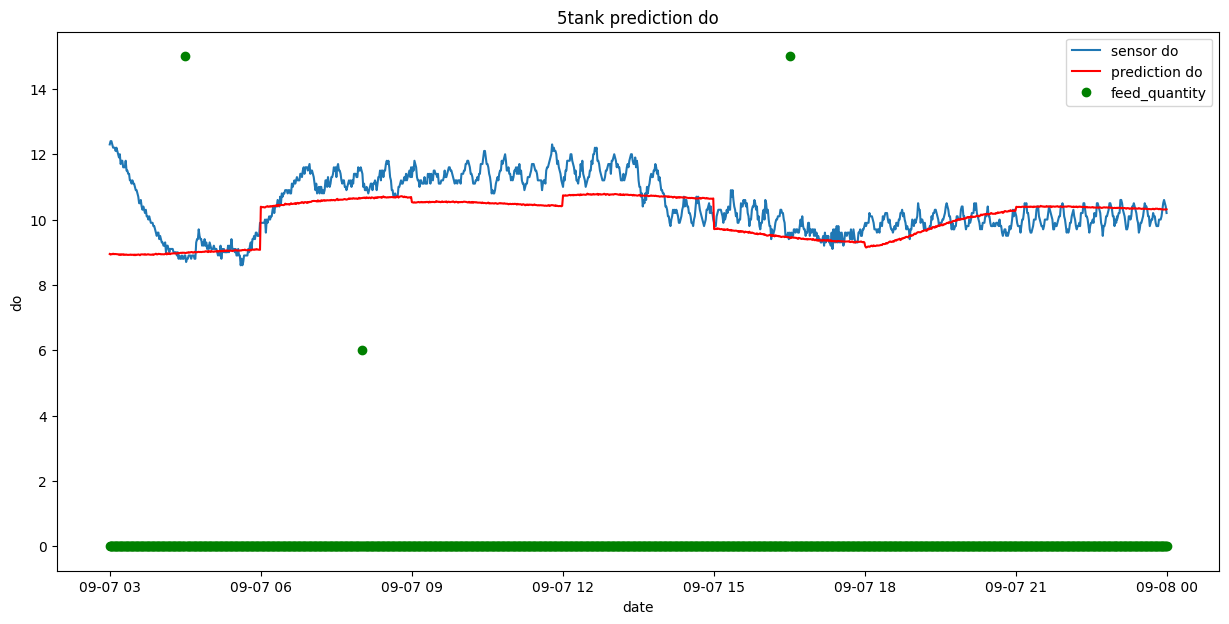

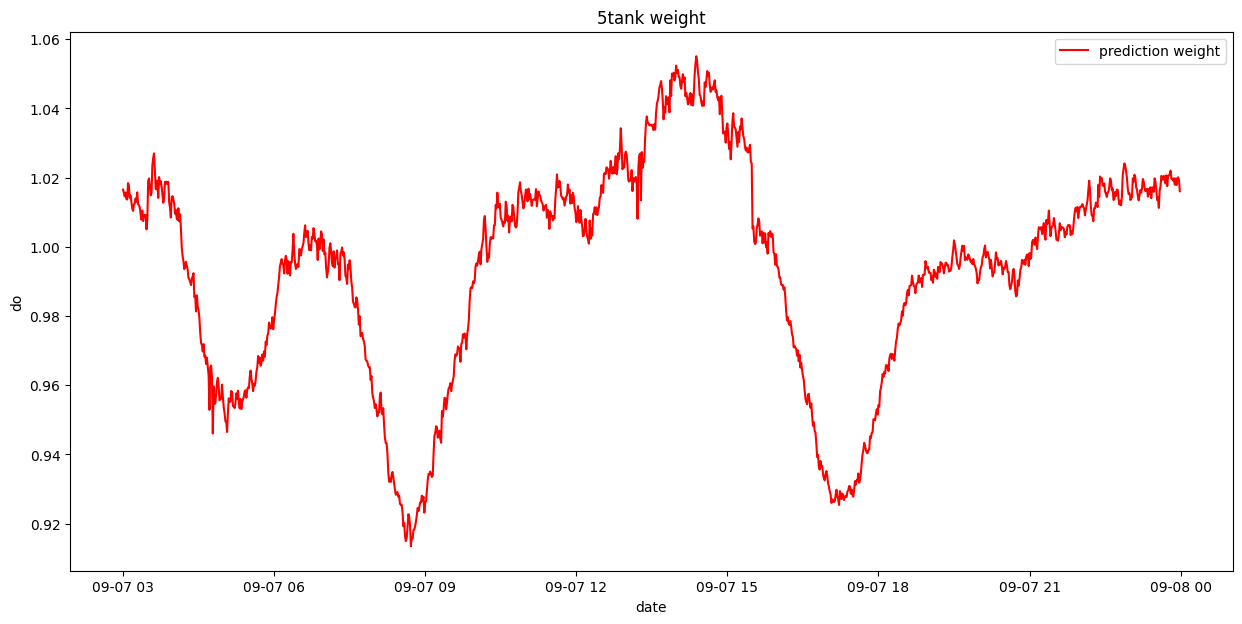

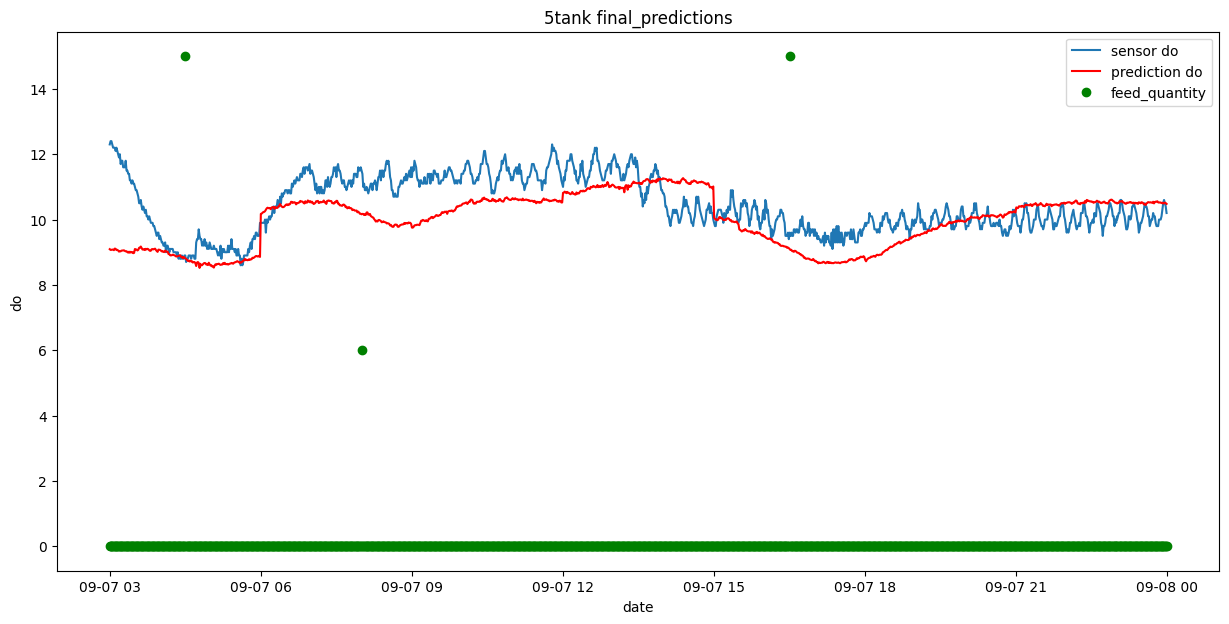

Euclidean Distance
 27.119725263007147  →  30.50505172739988
Cosine Similarity
 0.9979714753640309  →  0.9974176134146238
Correlation Coefficient
 0.36728574771057276  →  0.40837341605811384
Mean Squared Error
 0.5837138875722122  →  0.7385382388026527
Mean Absolute Error
 0.5689230988517641  →  0.6946887939638983
Correlation Coefficient
 0.6327142522894276  →  0.5916265839418866


In [84]:
y_date = japonica_validation_features_y.loc['2021-09-07 03:00':'2021-09-07 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-09-07 00:00':'2021-09-07 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-09-07 03:00':'2021-09-07 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

japonica_validation_features_X_a.at['2021-09-07 08:00', 'feed_quantity'] = 6
japonica_validation_features_X_b.at['2021-09-07 08:00', 'feed_quantity'] = 6

y_date = japonica_validation_features_y.loc['2021-09-07 03:00':'2021-09-07 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-09-07 00:00':'2021-09-07 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-09-07 03:00':'2021-09-07 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)